# Введение

In [36]:
import warnings
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes, fetch_openml,load_iris,fetch_california_housing
from sklearn.feature_selection import mutual_info_regression, f_regression, RFE, SelectFromModel, SelectKBest, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
RepeatedStratifiedKFold, 
cross_val_score, 
train_test_split, 
GridSearchCV,
cross_val_predict, 
learning_curve, 
validation_curve)
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error,zero_one_loss, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from os.path import join as pjoin
from mlxtend.evaluate import bias_variance_decomp
#sharper plots
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import (LogisticRegression, LogisticRegressionCV,
                                  SGDClassifier)

warnings.filterwarnings("ignore")

In [37]:
data_path = "../data/ml" 

## Проклятие размерности

 Проклятие размерности означает, что по мере увеличения количества объектов или измерений в наборе данных объем данных, необходимый для эффективного моделирования взаимосвязи между объектами и целевой переменной, растет экспоненциально.
Чем больше мы добавляем признаков, не увеличивая объем данных, используемых для обучения модели, тем больше увеличивается среднее расстояние между точками в пространстве признаков. Из-за такой разреженности становится гораздо проще найти удобное и совершенное, но не столь оптимальное решение для модели машинного обучения. Следовательно, модель плохо обобщает, что делает прогнозы ненадежными. Это может привести к таким проблемам, как переобучение и снижение точности.

 Чтобы смягчить проклятие размерности, можно использовать такие методы, как выбор признаков, уменьшение размерности и ансамблевые методы.

 Для примера рассмотрим 1000 случайных точек в пространствах размерности от 2 до 50. Построим график, показывающий это свойство.

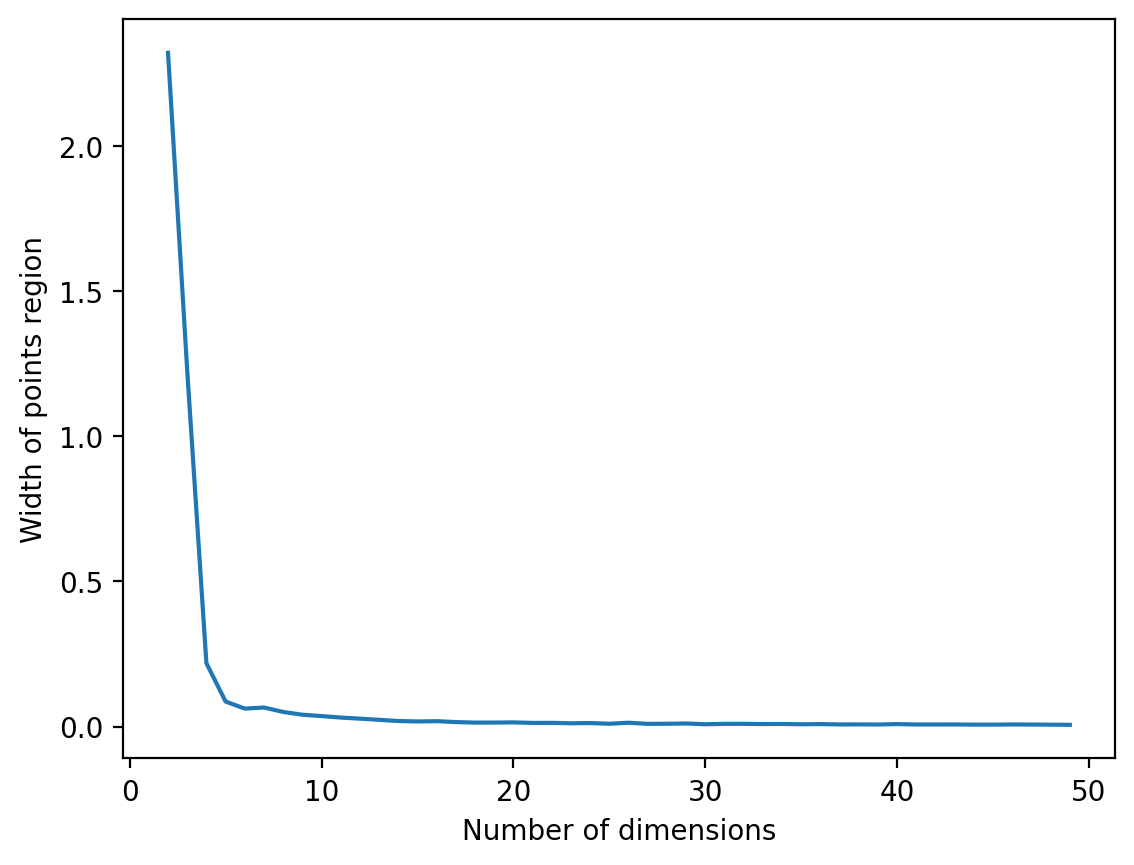

In [38]:
deltas = []
for N in range(2,50):
    # Generate 1000 random points in N dimensions.
    P = [np.random.randint(-100, 100, N) for _ in range(10000)]
    Q = np.random.randint(-100,100,N) #generate random point
    diffs = [np.linalg.norm(p-Q) for p in P]
    mxd = max(diffs)
    mnd = min(diffs)
    delta = math.log10(mxd-mnd)/mnd # this shows the tightness of points region
    deltas.append( delta )

plt.plot(range(2,50),deltas)
plt.xlabel('Number of dimensions')
plt.ylabel('Width of points region')
plt.show()

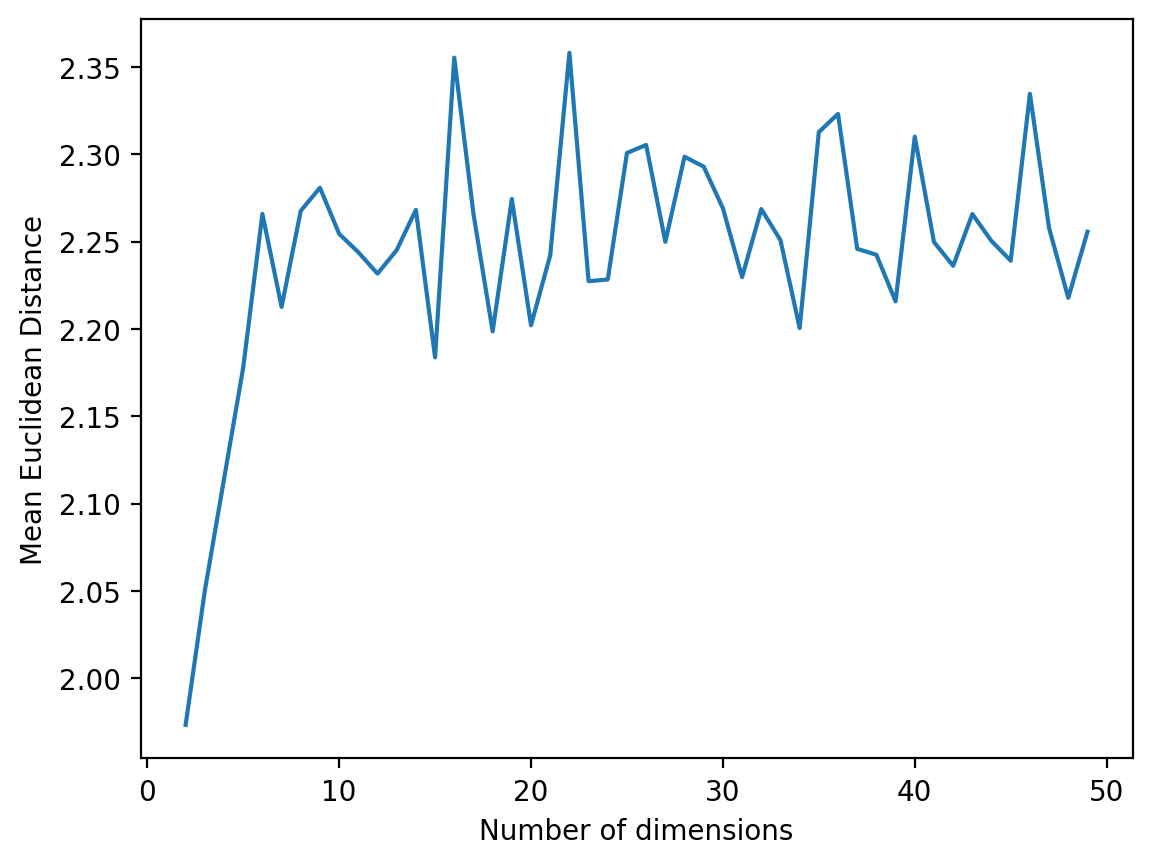

In [39]:
deltas = []
for N in range(2,50):
    # Generate 1000 random points in N dimensions.
    P = [np.random.randint(-100, 100, N) for _ in range(10000)]
    Q = np.random.randint(-100,100,N)
    diffs = [np.linalg.norm(p-Q) for p in P]
    mnd = min(diffs)
    delta = math.log10(sum(x-mnd for x in diffs) / 10000) # plot logarithm of mean distance
    deltas.append( delta )

plt.plot(range(2,50),deltas)
plt.xlabel('Number of dimensions')
plt.ylabel('Mean Euclidean Distance')
plt.show()

Для того, чтобы уменьшить влияние проклятия размерности, используются разные техники:
 - Feature selection. Выбор наиболее релевантных функций из набора данных может помочь уменьшить размерность и повысить производительность модели.
 - Снижение размерности. Такие методы, как анализ главных компонент (PCA), линейный дискриминантный анализ (LDA) и t-SNE, могут использоваться для уменьшения размерности данных при сохранении наиболее важной информации.
 - Регуляризация. Методы регуляризации, такие как L1 и L2, могут помочь предотвратить переобучение в многомерных наборах данных путем добавления штрафного члена к функции потерь.
 - Ансамблевые методы. Объединение результатов нескольких моделей также может помочь повысить производительность в многомерных наборах данных.
 - Увеличение размера набора обучающих данных также может помочь преодолеть проклятие размерности, однако сбор большего количества данных может занять много времени и стоит дорого.
 - Генерация синтетических данных. Генерацию синтетических данных также можно использовать для увеличения размера набора данных, особенно когда сбор большего количества реальных данных невозможен.

Рассмотрим несколько вариантов решений.

### Feature selection

UCI MAGIC dataset: https://archive.ics.uci.edu/ml/datasets/magic+gamma+telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

Телескопами MAGIC в настоящее время управляют около 165 астрофизиков из 24 организаций и консорциумов из 12 стран. MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

В наборе данных хранятся параметры зарегистрированных "фотографий" излучений потоков частиц от этих телескопов. Они делятся на  кванты (фотоны) и адроны (протоны). 
Описание признаков:

- Length: continuous # major axis of ellipse [mm]
- Width: continuous # minor axis of ellipse [mm]
- Size: continuous # 10-log of sum of content of all pixels [in #phot]
- Conc: continuous # ratio of sum of two highest pixels over fSize [ratio]
- Conc1: continuous # ratio of highest pixel over fSize [ratio]
- Asym: continuous # distance from highest pixel to center, projected onto major axis [mm]
- M3Long: continuous # 3rd root of third moment along major axis [mm]
- M3Trans: continuous # 3rd root of third moment along minor axis [mm]
- Alpha: continuous # angle of major axis with vector to origin [deg]
- Dist: continuous # distance from origin to center of ellipse [mm]
- Label: g,h # gamma (signal), hadron (background)

g = gamma (signal): 12332 

h = hadron (background): 6688

In [40]:
columns = np.array(["Length", "Width", "Size", "Conc", "Conc1", "Asym", "M3Long", "M3Trans", "Alpha", "Dist"])

data = pd.read_csv(pjoin(data_path, "magic.txt"),header=None, names=list(columns)+["Label"])

In [41]:
X = data[columns].values
y = 1 * (data['Label'].values == "g")

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11, stratify=y)

**Задание**: Проведите краткий EDA, определите, как выглядят признаки, есть ли пропуски итд

In [43]:
# YOUR CODE
df = data.copy()
df.head(10)

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,Label
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
5,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.0980,g
6,48.2468,17.3565,3.0332,0.2529,0.1515,8.5730,38.0957,10.5868,4.7920,219.0870,g
7,26.7897,13.7595,2.5521,0.4236,0.2174,29.6339,20.4560,-2.9292,0.8120,237.1340,g
8,96.2327,46.5165,4.1540,0.0779,0.0390,110.3550,85.0486,43.1844,4.8540,248.2260,g
9,46.7619,15.1993,2.5786,0.3377,0.1913,24.7548,43.8771,-6.6812,7.8750,102.2510,g


In [44]:
print(df['Label'].unique())

df['Label'] = df['Label'].replace({"g": 1, "h": 0})
df.head(10)

['g' 'h']


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,Label
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1
5,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.0980,1
6,48.2468,17.3565,3.0332,0.2529,0.1515,8.5730,38.0957,10.5868,4.7920,219.0870,1
7,26.7897,13.7595,2.5521,0.4236,0.2174,29.6339,20.4560,-2.9292,0.8120,237.1340,1
8,96.2327,46.5165,4.1540,0.0779,0.0390,110.3550,85.0486,43.1844,4.8540,248.2260,1
9,46.7619,15.1993,2.5786,0.3377,0.1913,24.7548,43.8771,-6.6812,7.8750,102.2510,1


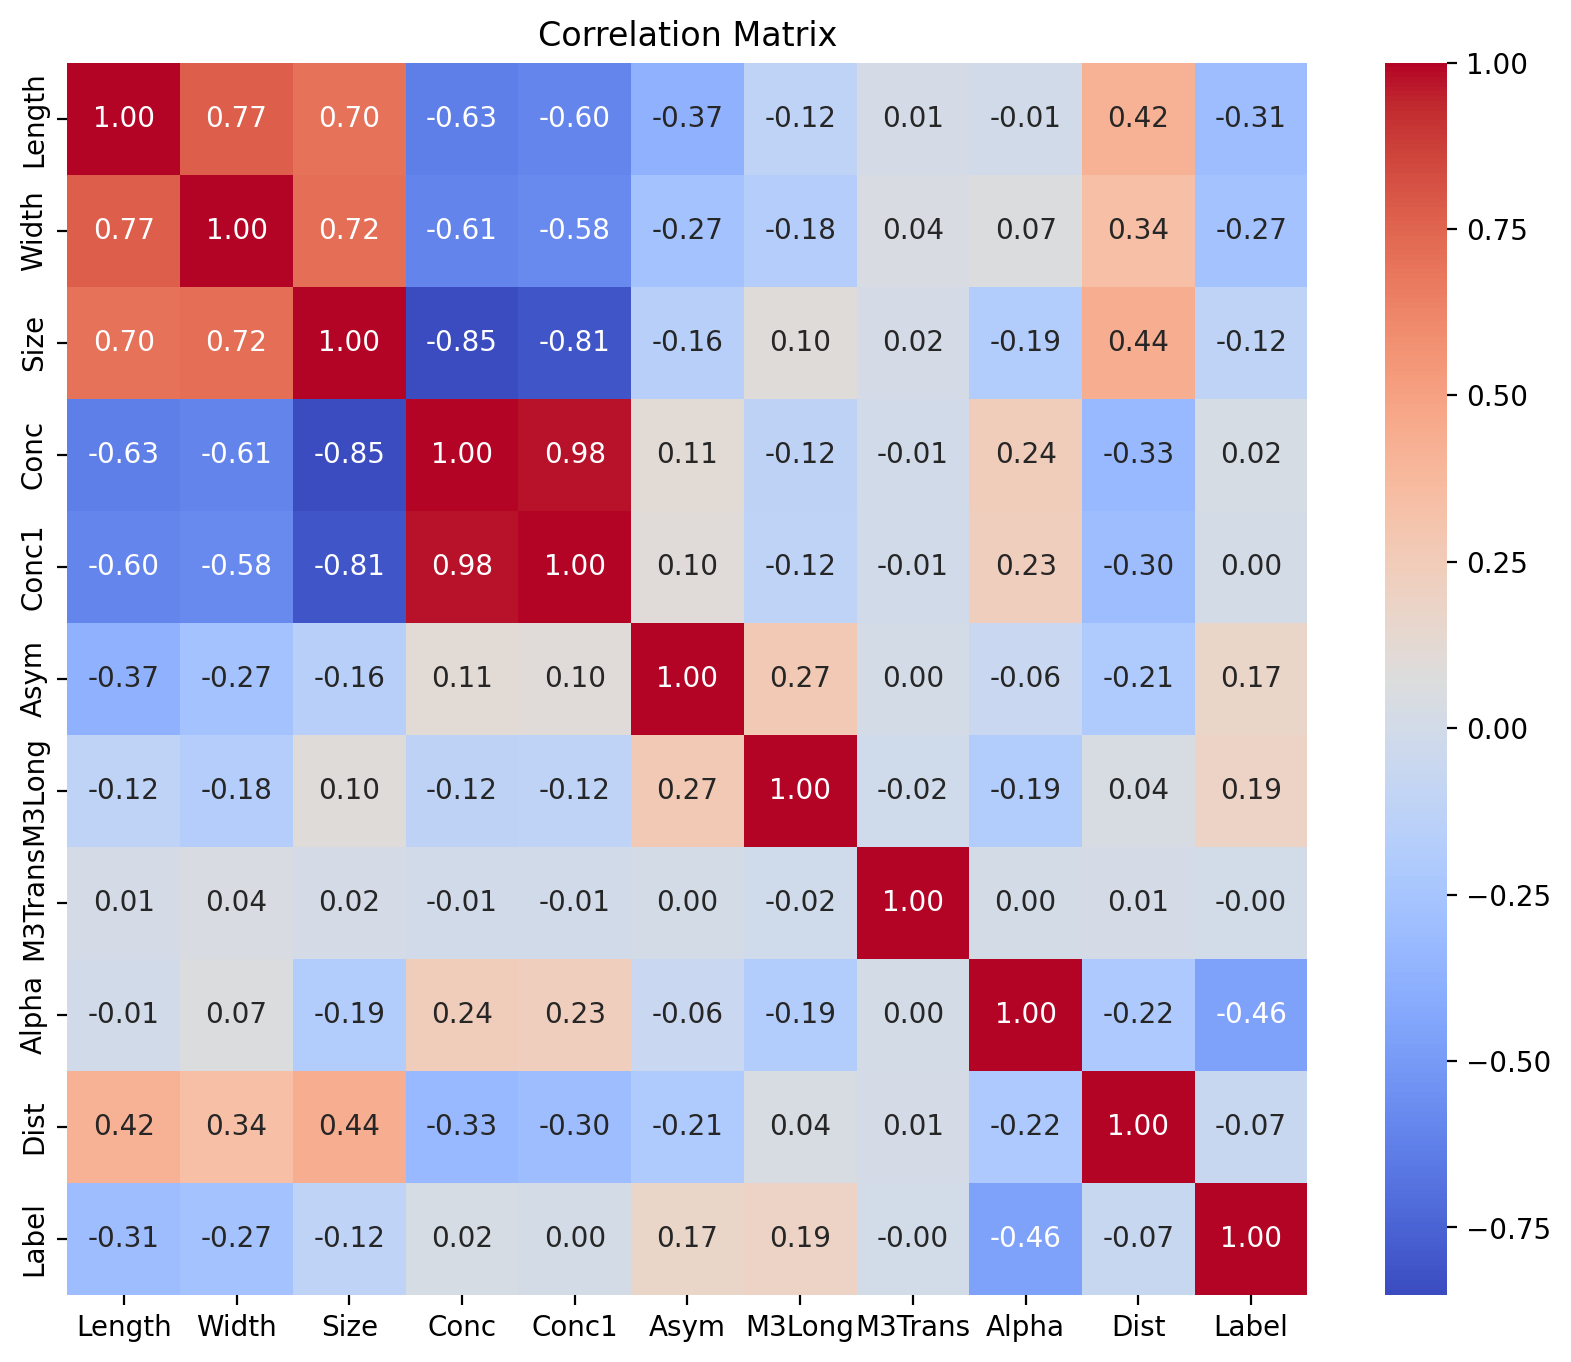

In [45]:
# corrplot
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [46]:
print(df.isna().sum())
print()
print(df.isnull().sum())

Length     0
Width      0
Size       0
Conc       0
Conc1      0
Asym       0
M3Long     0
M3Trans    0
Alpha      0
Dist       0
Label      0
dtype: int64

Length     0
Width      0
Size       0
Conc       0
Conc1      0
Asym       0
M3Long     0
M3Trans    0
Alpha      0
Dist       0
Label      0
dtype: int64


Самый простой способ выбора признаков - Information gain (прирост информации). Прирост информации — это статистика, которая измеряет снижение энтропии (неопределенности) для конкретной функции (таргета) путем деления данных в соответствии с этой характеристикой. Формально, он определен с помощью взаимной информации (I(X , Y) = H(X) – H(X | Y)). Она часто используется в алгоритмах дерева решений, а также имеет другие полезные свойства. Чем выше прирост информации от признака использования признака, тем полезнее он для принятия решений.


In [47]:
# Apply Information Gain
ig = mutual_info_regression(X_train, y_train)

# Create a dictionary of feature importance scores
feature_scores = {}
for i, col in enumerate(list(columns)):
    feature_scores[col ] = ig[i]

# Sort the features by importance score in descending order
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance scores and the sorted features
for feature, score in sorted_features:
    print(f"Feature: {feature}, Score: {score}")

Feature: Alpha, Score: 0.12170424219613807
Feature: Width, Score: 0.09376478790854392
Feature: Length, Score: 0.08053481059532253
Feature: M3Long, Score: 0.07560091115241896
Feature: M3Trans, Score: 0.06503057492803954
Feature: Size, Score: 0.04603629260873454
Feature: Asym, Score: 0.04316594377559113
Feature: Conc, Score: 0.022651785407211023
Feature: Conc1, Score: 0.022094012015996256
Feature: Dist, Score: 0.01603183148149334


In [48]:
def plot_feature_importances(f_imps, f_names, title=""):
    f_imps = np.array(f_imps)
    f_names = np.array(f_names)
    sort_inds = np.argsort(f_imps)
    yy = np.arange(len(f_imps)).astype(int)
    plt.barh(yy, f_imps[sort_inds])
    plt.yticks(yy, f_names[sort_inds], size=14)
    plt.xticks(size=14)
    plt.xlabel("Feature importance", size=14)
    plt.title(title, size=14)
        
    # Add importance scores as labels on the horizontal bar chart
    for i, v in enumerate(f_imps[sort_inds]):
        plt.text(v + 0.01, i, str(round(v, 3)), color="black", fontweight="bold")
    plt.show()

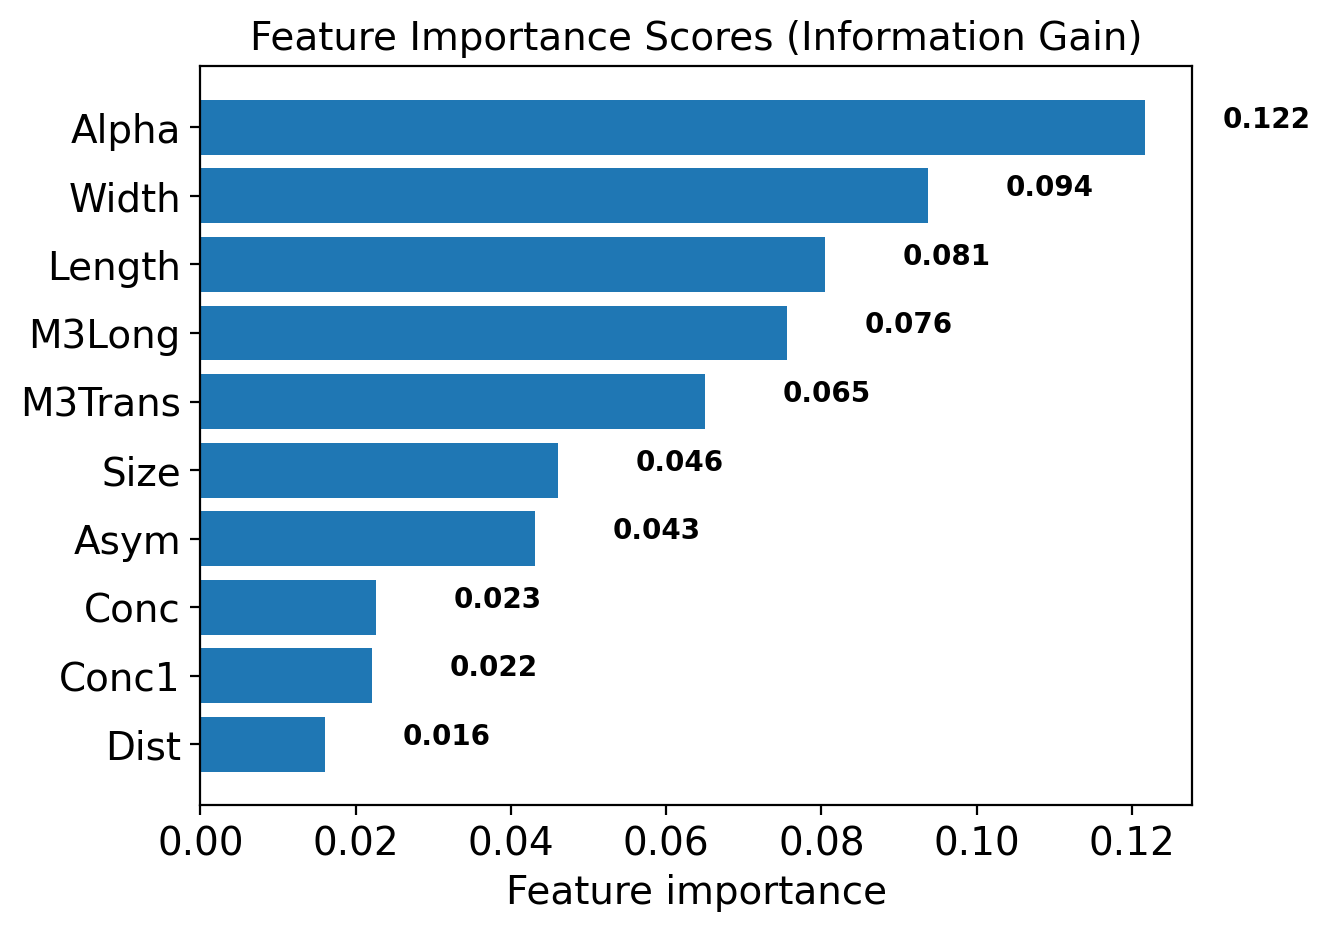

In [49]:
plot_feature_importances(list(feature_scores.values()), list(feature_scores.keys()), title="Feature Importance Scores (Information Gain)")

Вопрос: какие из этих признаков можно считать важными? 

Другой вариант - F test. F-Test выполняет проверку гипотез по моделям X и Y, где X — это модель, созданная только с помощью константы, а Y — это модель, созданная с помощью константы и функции.

Ошибки в обеих моделях сравниваются и проверяется, являются ли различия в ошибках между моделями X и Y значительными или они внесены случайно:

Для каждого признака ошибка
$$E[(X[:, i] - mean(X[:, i])) * (y - mean(y))] / (std(X[:, i]) * std(y))$$
преобразуется в F-статистику, после чего рассчитывается уровень значимости признака.

Есть некоторые недостатки использования F-Test для выбора функций. F-Test проверяет и фиксирует только линейные связи между признаками и таргетами. Высококоррелированному признаку присваивается более высокий балл, а менее коррелированному признаку — более низкий балл. Однако даже  сильные нелинейные связи этот тест не выявит.

In [50]:
f_statistic, p_values = f_classif(X_train, y_train)
feature_scores = {}
feature_scores = {}
for i, col in enumerate(list(columns)):
    feature_scores[col] = (f_statistic[i], p_values[i])

# Sort the features by importance score in descending order
sorted_features = sorted(
    feature_scores.items(), key=lambda x: x[1], reverse=True
    )

# Print the feature importance scores and the sorted features
for feature, score in sorted_features:
    print(f"Feature: {feature}, Score: {score[0]}, p-value: {score[1]}")

Feature: Alpha, Score: 3598.8825865588283, p-value: 0.0
Feature: Length, Score: 1436.719050932082, p-value: 1.2023326674804604e-298
Feature: Width, Score: 1027.7857329354808, p-value: 2.6743256315496476e-217
Feature: M3Long, Score: 550.9978582605704, p-value: 2.0026838747965496e-119
Feature: Asym, Score: 420.08393989089376, p-value: 6.1043516013500926e-92
Feature: Size, Score: 208.22845160615563, p-value: 7.5462698144895985e-47
Feature: Dist, Score: 64.22418465342753, p-value: 1.2023775293216669e-15
Feature: Conc, Score: 12.064570946889292, p-value: 0.000515524915007528
Feature: Conc1, Score: 1.3535427769611676, p-value: 0.24468057037956897
Feature: M3Trans, Score: 0.07157075566166207, p-value: 0.7890674868440286


**Вопрос**: Какие из столбцов можно считать важными, основываясь на этом тесте? Поясните свой ответ.

**Задание**: 
1) Постройте модель логистической регрессии, используя все признаки из набора.
2) Также постройте модели для вабранных наборов признаков.

In [51]:
#1) Постройте модель логистической регрессии, используя все признаки из набора.

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

significant_features = np.array(columns)[np.array(p_values) < 0.05]

log_reg_with_signif = LogisticRegression()
log_reg_with_signif.fit(X_train[:, [i for i, c in enumerate(columns) if c in significant_features]], y_train)

print("all feat: ", log_reg.score(X_test, y_test))
print("signif feat: ", log_reg_with_signif.score(X_test[:, [i for i, c in enumerate(columns) if c in significant_features]], y_test))


all feat:  0.7891692954784437
signif feat:  0.7861899754644234


In [55]:
def print_feature_names(features, original_feature_names: list  | None = None):
    if features is not None:
        print(f"Selected features: {features}")
    else:
        print(f"Selected features: {original_feature_names}")

def select_features(X_train, y_train, X_test, function, k: int = 5, features: list  | None = None):
# configure to select a subset of features
  fs = SelectKBest(score_func=function, k=k)
  fs.fit(X_train, y_train)
  # YOUR CODE: print feature names. Hint: Use the method of fs, which saves out features

  print_feature_names(features, fs.get_feature_names_out())

  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

In [56]:
model = DecisionTreeClassifier()
cross_val_score(
    model, X, y, scoring="accuracy", cv=5
).mean()

0.8165615141955836

In [57]:
results = {"num_features": [], "acc": [], "roc_auc": []}
for i in range(1, len(columns)):
    results["num_features"].append(i)
    # feature selection
    X_train_fs, X_test_fs, fs = select_features(
        X_train, y_train, X_test, f_classif, k=i, features = list(columns)
        )
    # fit the model
    model = DecisionTreeClassifier()
    model.fit(X_train_fs, y_train)
    yhat = model.predict(X_test_fs)
    probs = model.predict_proba(X_test_fs)[:, 1]
    # evaluate predictions
    results["acc"].append(accuracy_score(y_test, yhat))
    results["roc_auc"].append(roc_auc_score(y_test, probs))
results = pd.DataFrame(results)

Selected features: ['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist']
Selected features: ['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist']
Selected features: ['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist']
Selected features: ['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist']
Selected features: ['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist']
Selected features: ['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist']
Selected features: ['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist']
Selected features: ['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist']
Selected features: ['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist']


In [58]:
results

,num_features,acc,roc_auc
0,1,0.654399,0.623426
1,2,0.752015,0.727761
2,3,0.769716,0.750881
3,4,0.784613,0.763965
4,5,0.789695,0.771650
5,6,0.811602,0.794134
6,7,0.814055,0.796368
7,8,0.818086,0.798563
8,9,0.821416,0.802956


Мы можем также оценить признаки, используя сам классификатор. В случае с деревьями, лесами и бустингами это очень естественно.

Пусть $T(f)$ все ноды, использующие фичу $f$ для разбиения. Tогда, важность фичи $Imp(f)$ of $f$:
    $$Imp(f) = \sum_{t \in T(f)} n_t \Delta I(t),$$
    $$\Delta I(t) = I(t) - \sum_{c \in children} \frac{n_c}{n_t} I(c),$$
где $n_{t}$ - число объектов в ноде $t$; $I(t)$ – impurity function (gini, cross-entropy, MSE) в ноде $t$
  
В случае ансамбля важности фичей усредняются между деревьями.

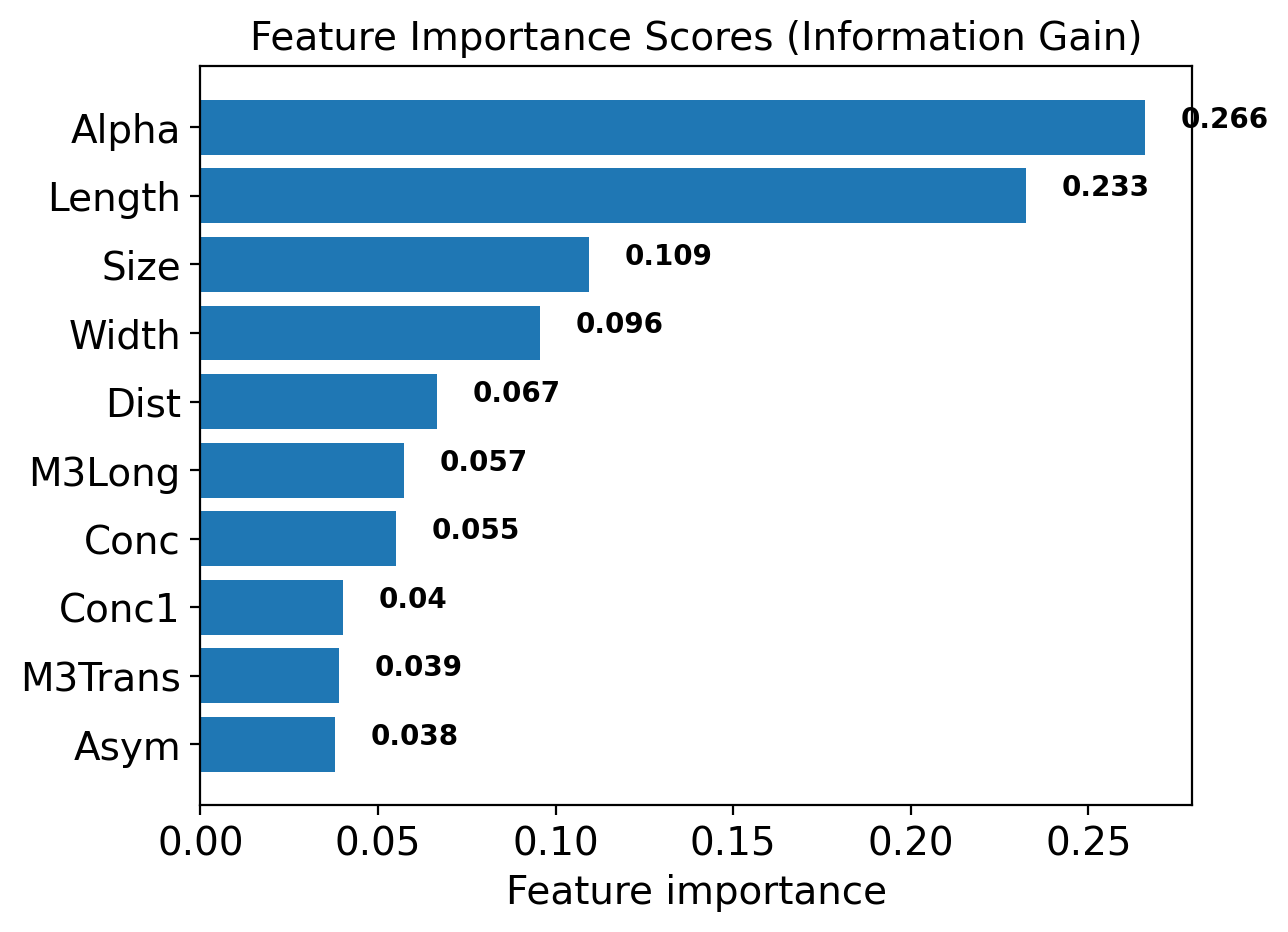

In [59]:
model.fit(X_train, y_train)
plot_feature_importances(model.feature_importances_, columns, title="Feature Importance Scores (Information Gain)")

В случае линейной модели, важность признака тоже можно оценить. В случае отнормализованных признаков, оценкой важности выступает модель соответствующего коэффициента.

**Задание**: Оцените важность признаков, используя линейную модель. 
Подсказка: используйте l2 регуляризацию и <model>.coef_[0] для получения коэффициентов.

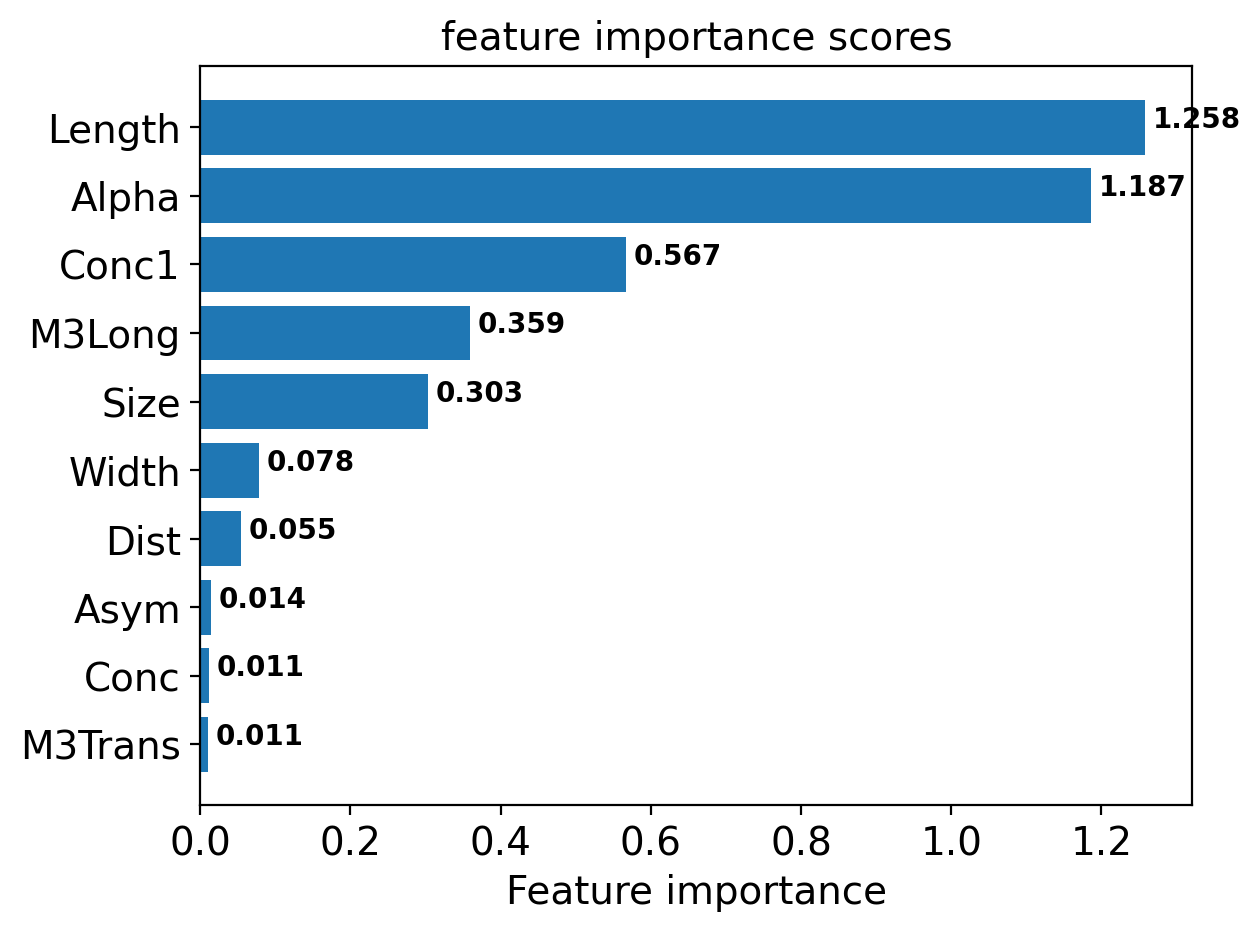

In [62]:
def get_feature_imp_with_lin_mod(X_train, y_train, C=1.0):
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_ss = ss.transform(X_train)
    ### YOUR CODE
    model = LogisticRegression(C=C, penalty="l2", solver="lbfgs", random_state=11)
    model.fit(X_train_ss, y_train)
    f_imps_lin = np.abs(model.coef_[0])
    ### YOUR CODE
    return f_imps_lin

plot_feature_importances(
    get_feature_imp_with_lin_mod(X_train, y_train),
    columns,
    title="feature importance scores",
)

Как видно, для разных моделей оценки сильно отличаются. 
Общий метод оценки важности: 
1) Обучите свою модель
2) Рассчитайте метрику качества  $Q_o$  на тестовом наборе
3) Для признака $f$:
     1) Замените значения случайными значениями из того же распределения (выполните случайное перемешивание)
     2) Рассчитайте метрику качества $Q_r$ на тестовом наборе 
     3) Оцените важность признака: $Imp(f) = Q_0 - Q_r$

**Задание**: Реализуйте такой метод, используя линейную модель с регуляризацией.

**Бонусное задание**: Сделайте метрику аргументом, проведите тесты с линейной моделью, деревом решений, случайным лесом, двумя метриками. Постройте таблицу со сравнением.

In [71]:
def get_feature_imp_general(X_test, y_test, model, metric=accuracy_score):
    
    feature_importances = []
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
        if metric == roc_auc_score:
            q_0 = metric(y_test, probs)
        else:
            q_0 = metric(y_test, model.predict(X_test))
    else:
        q_0 = metric(y_test, model.predict(X_test))
    for i in range(X_test.shape[1]):
        X_test_copy = X_test.copy()
        np.random.shuffle(X_test_copy[:, i])
        X_test_copy = np.nan_to_num(X_test_copy)
        y_hat = model.predict(X_test_copy)
        q_r = accuracy_score(y_test, y_hat)
        importance = q_0 - q_r
        feature_importances.append(importance)
    return np.array(feature_importances)

In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(random_state=11, penalty="l2"),
    "Decision Tree": DecisionTreeClassifier(random_state=11),
    "Random Forest": RandomForestClassifier(random_state=11),
}

results = []

for name, model in models.items():
    X_tested = X_test_scaled if name == "Logistic Regression" else X_test
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
    else:
        model.fit(X_train, y_train)

    importances = get_feature_imp_general(X_tested, y_test, model)
    for i, col in enumerate(importances):
        results += [{'model':name, 'metric':accuracy_score, 'feat':columns[i], 'imp':col}]
    importances = get_feature_imp_general(X_tested, y_test, model, metric=roc_auc_score)
    for i, col in enumerate(importances):
        results += [{'model':name, 'metric':roc_auc_score, 'feat':columns[i], 'imp':col}]
results = pd.DataFrame(results)
    
        

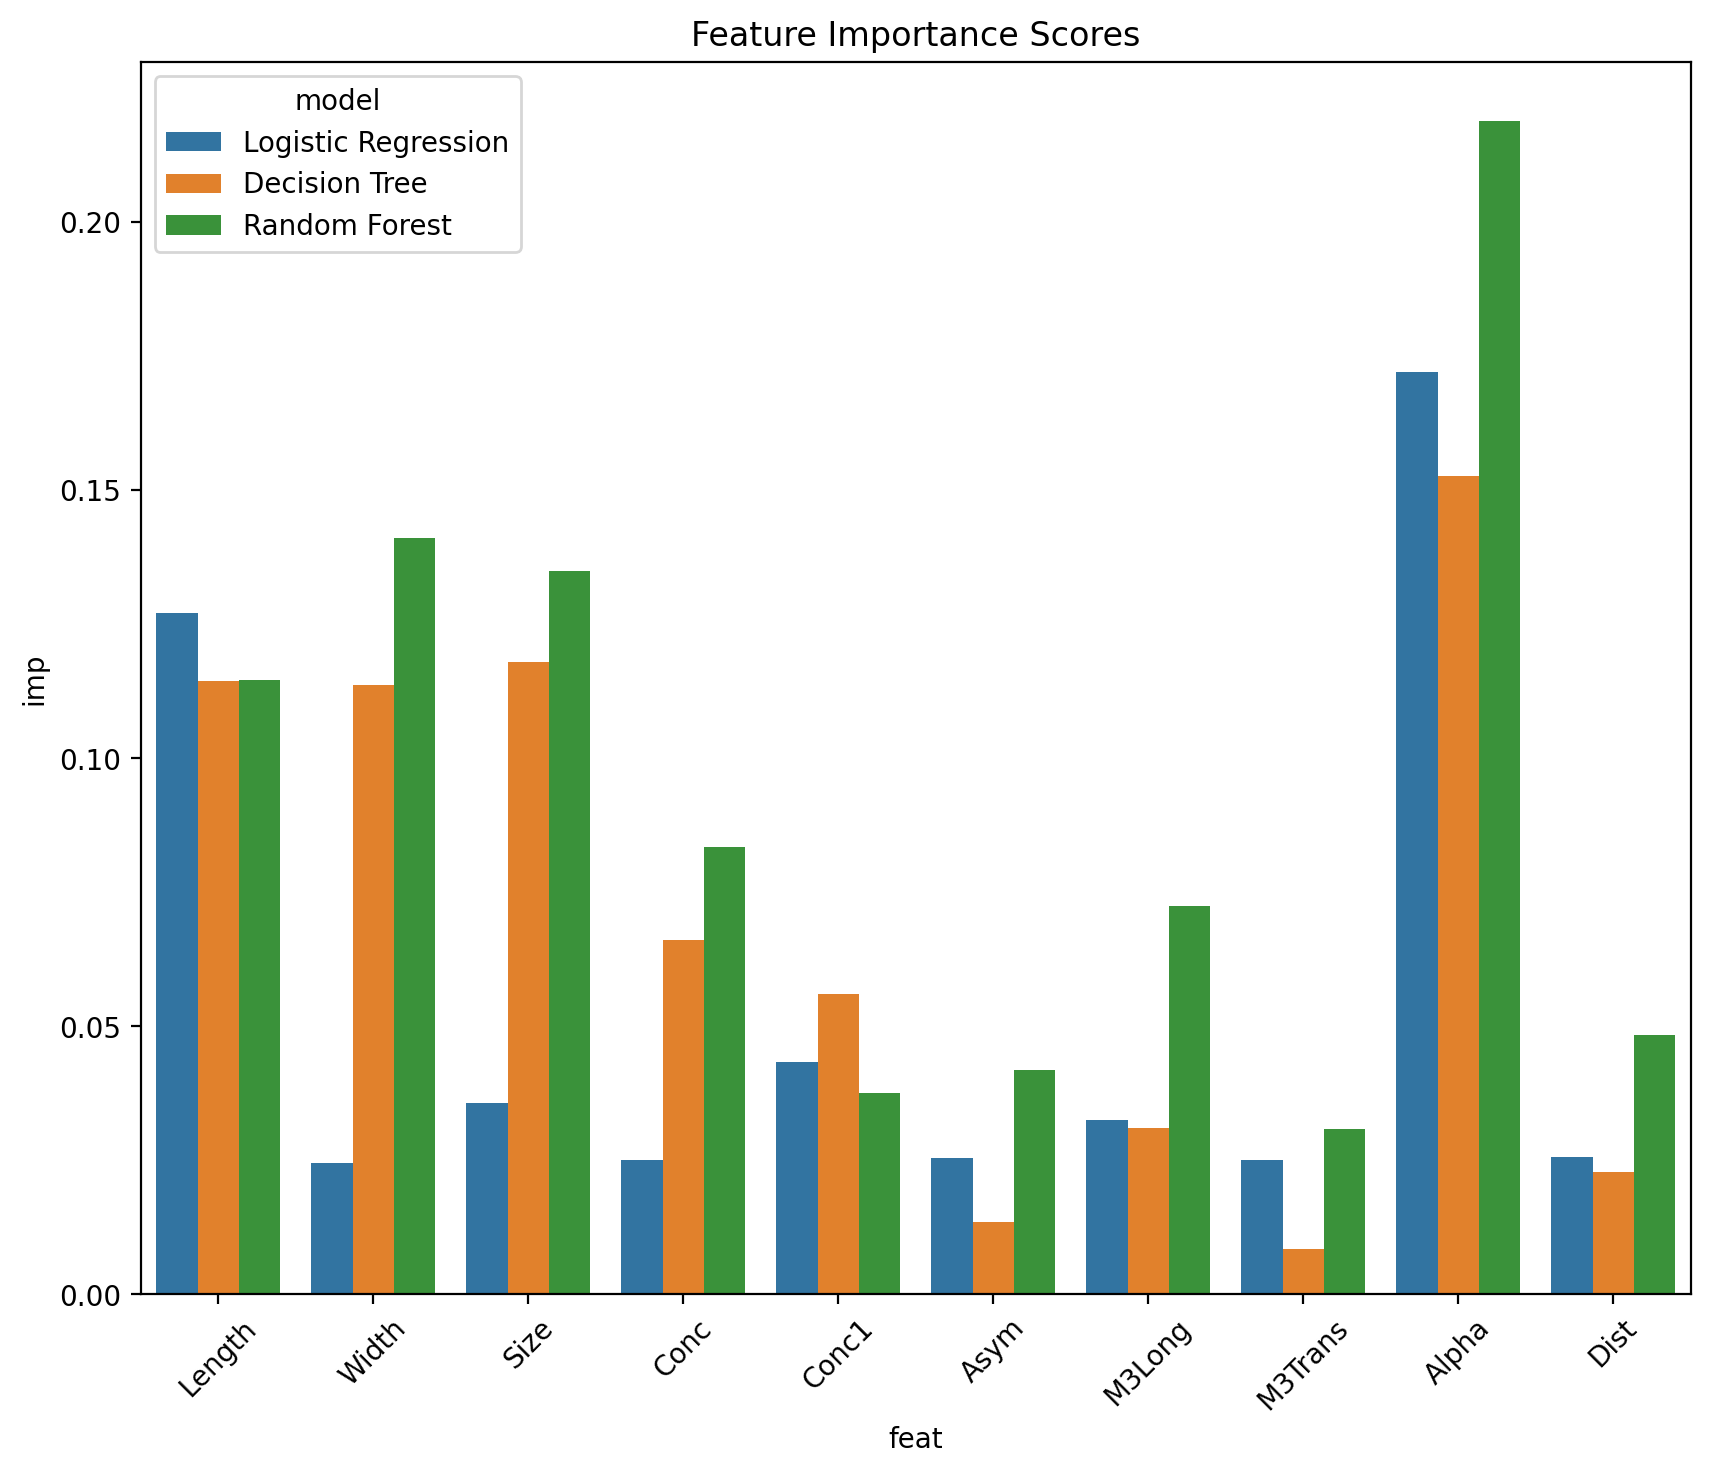

In [85]:
plt.figure(figsize=(10, 8))
sns.barplot(
    results,
    x="feat",
    y="imp",
    hue="model",
    ci=None,
)
plt.xticks(rotation=45)
plt.title("Feature Importance Scores")
plt.show()

Как же перейти от простой оценки важности признаков к поиску такого подмножества, которое приведет к наибольшей точности модели?
Можно использовать рекурсиввный выбор признаков (Recursive feature selection, или RFE).
RFE работает путем поиска подмножества признаков, начиная со всех признаков в наборе и постепенно удаляя самые незначимые, пока не останется желаемое количество.

Это достигается путем подбора модели для оценки, ранжирования признаков по важности, отбрасывания наименее важного признака и повторного обучения модели. Этот процесс повторяется до тех пор, пока не останется заданное количество признаков. Характеристики оцениваются либо с использованием предоставленной модели, либо с использованием статистического метода, такого как f-score или IG.

В sklearn реализован класс трансформера для такого подбора, при этом подюор может быть отделен от основной модели. 

In [86]:
# scaler = StandardScaler()
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=5)
model = LogisticRegression()
#pipeline = Pipeline(steps=[('sc',scaler),('s',rfe),('m',model)])
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
pipeline.fit(X_train, y_train)
print_feature_names(rfe.get_feature_names_out(), columns)
# evaluate the model
y_hat = pipeline.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, y_hat)
print('Accuracy: %.3f' % acc)

Selected features: ['x0' 'x1' 'x2' 'x8' 'x9']
Accuracy: 0.785


**Задание**: Реализуйте данный метод вручную. Бонусное задание: реализуйте класс трансформера для подбора и/или конфигурируемые метрику и модель.

In [96]:
def find_best_features_set(X_train, y_train, X_test, y_test, model, columns, n_features):
    """
    Recursive feature elimination
    """
    X_train_curr = X_train.copy()
    X_test_curr  = X_test.copy()
    f_names_curr = np.array(columns).copy()

    # define a list for the feature importances
    scores = []
    # for each feature in the sample estimate its importance
    
    while X_test_curr.shape[1] > n_features:
        model.fit(X_train_curr, y_train)
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif hasattr(model, "coef_"):
            importances = np.abs(model.coef_[0])
        else:
            assert 0 == 1
        
        y_hat = model.predict(X_test_curr)
        score = accuracy_score(y_test, y_hat)
        print("Score: ", np.round(score, 4))
        scores.append(score)
    
        # remove feature with the least importance
        
        print('features:', X_train_curr.shape[1], 
            #   'importance:', importances,
              'score:', score)
        
        least_important = np.argmin(importances)
        l = np.ones(X_train_curr.shape[1], dtype=bool)
        l[least_important] = False
        X_train_curr = X_train_curr[:, l]
        X_test_curr  = X_test_curr[:, l]
        f_names_curr = f_names_curr[l]
    return scores, f_names_curr

Score:  0.7892
features: 10 score: 0.7891692954784437
Score:  0.7876
features: 9 score: 0.7875920084121977
Score:  0.7874
features: 8 score: 0.7874167542937259
Score:  0.7879
features: 7 score: 0.7879425166491413
Score:  0.7878
features: 6 score: 0.7877672625306694


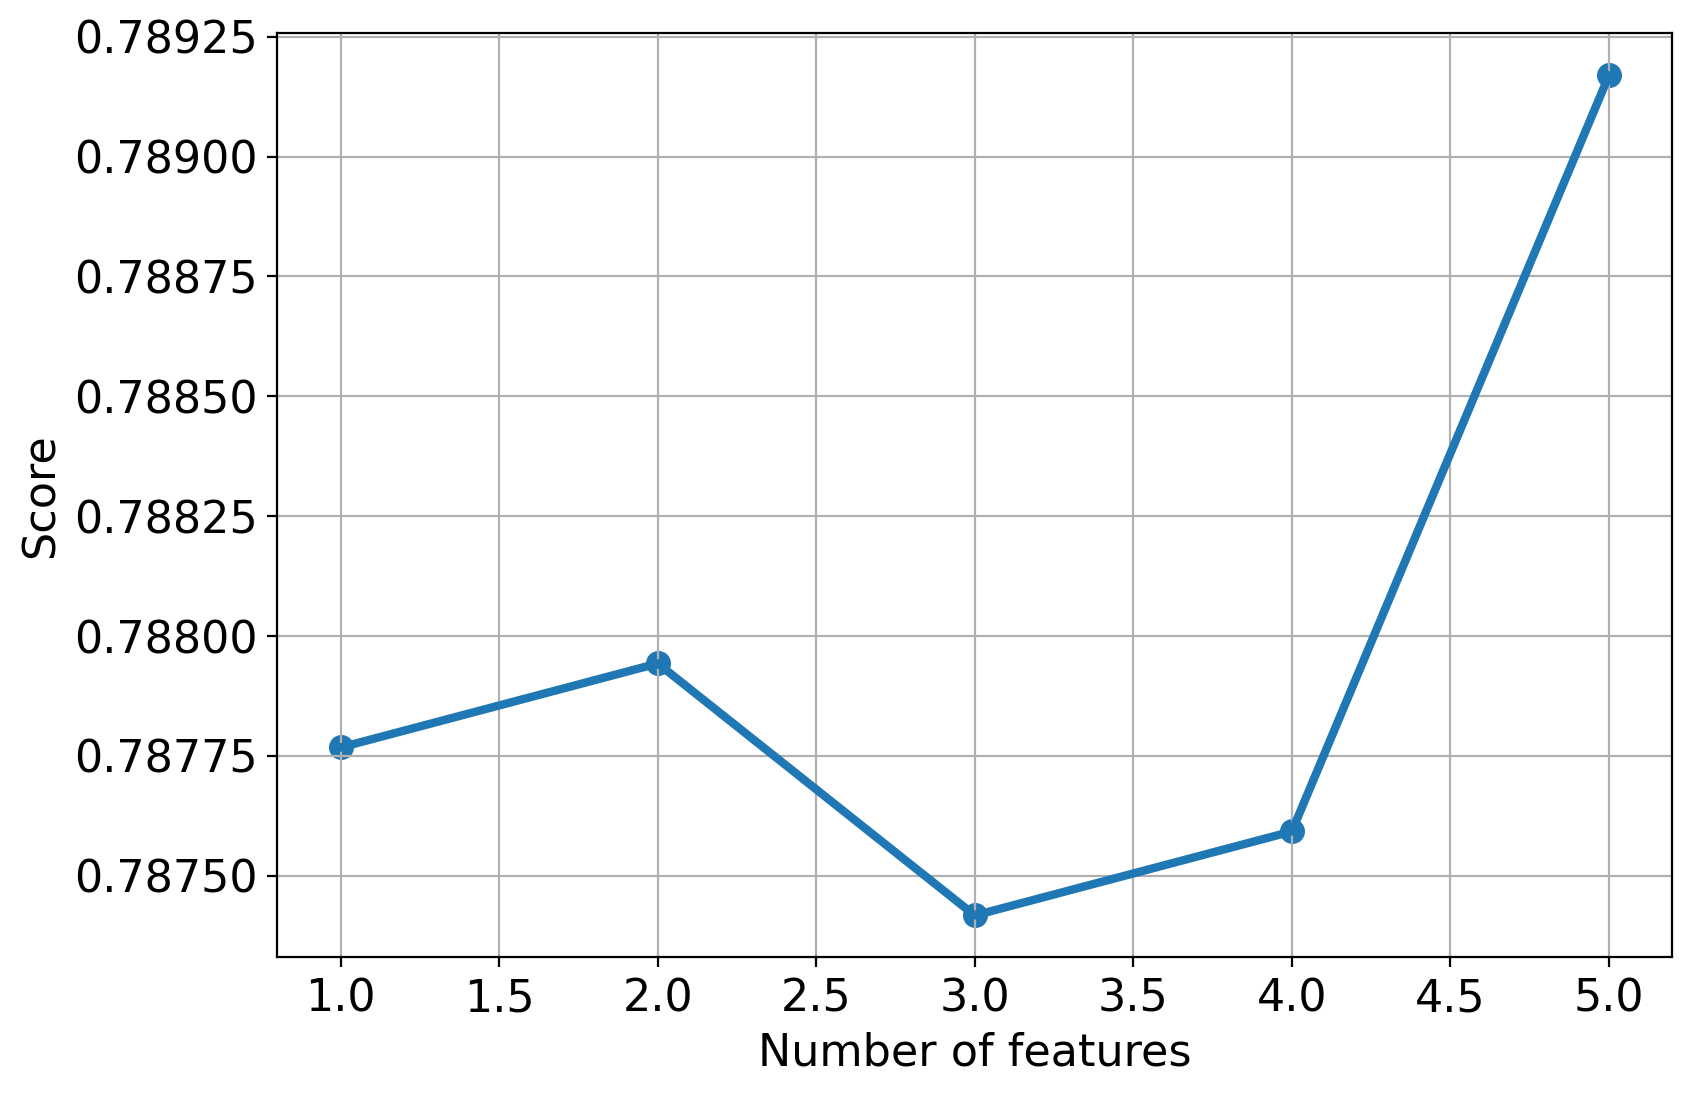

In [97]:
scores, f_names  = find_best_features_set(X_train, y_train, X_test, y_test, model, columns, X_train.shape[1]//2)
nf = np.arange(1, len(scores)+1)[::-1]
plt.figure(figsize=(9, 6))

plt.plot(nf, scores, linewidth=3)
plt.scatter(nf, scores, linewidth=3)

plt.xlabel("Number of features", size=16)
plt.ylabel("Score", size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.grid()
plt.show()

In [99]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

class RFETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, estimator, scoring=accuracy_score, min_features=1):
        self.estimator = estimator
        self.scoring = scoring
        self.min_features = min_features

    def fit(self, X, y):
        X_curr = X.copy()
        self.feature_names_ = np.array([f"f{i}" for i in range(X.shape[1])])
        self.ranking_ = []
        self.scores_ = []
        
        while X_curr.shape[1] >= self.min_features:
            self.estimator.fit(X_curr, y)
            if hasattr(self.estimator, "coef_"):
                if self.estimator.coef_.ndim > 1:
                    importances = np.mean(np.abs(self.estimator.coef_), axis=0)
                else:
                    importances = np.abs(self.estimator.coef_).flatten()
            elif hasattr(self.estimator, "feature_importances_"):
                importances = self.estimator.feature_importances_
            else:
                assert 0==1
            
            self.ranking_.append(self.feature_names_.copy())
            score = self.scoring(y, self.estimator.predict(X_curr))
            self.scores_.append(score)
            
            if X_curr.shape[1] == self.min_features:
                break
            
            min_idx = np.argmin(importances)
            X_curr = np.delete(X_curr, min_idx, axis=1)
            self.feature_names_ = np.delete(self.feature_names_, min_idx)
            
        return self

    def transform(self, X):
        return X[:, [int(col[1:]) for col in self.feature_names_]]


In [102]:
rfe_transformer = RFETransformer(
    estimator=LogisticRegression(solver="liblinear"),
    scoring=accuracy_score,
    min_features=5
)

pipeline= Pipeline(steps=[('s', rfe_transformer), ('m', LogisticRegression(solver="liblinear"))])
pipeline.fit(X_train, y_train)
print("Selected features:", pipeline.named_steps["s"].feature_names_)

y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Selected features: ['f0' 'f2' 'f3' 'f4' 'f8']
Accuracy: 0.7874167542937259


### PCA

[Ноутбук Евгения Соколова](https://github.com/esokolov/ml-course-hse/blob/master/2022-spring/seminars/sem14_pca_tsne.ipynb)

Выделение новых признаков путем их отбора часто дает плохие результаты, и в некоторых ситуациях такой подход практически бесполезен. Например, если мы работаем с изображениями, у которых признаками являются яркости пикселей,
невозможно выбрать небольшой поднабор пикселей, который дает хорошую информацию о содержимом картинки. Поэтому признаки нужно как-то комбинировать.\n",

__Метод главных компонент__ &mdash; один из самых интуитивно простых и часто используемых методов для снижения размерности данных и проекции их на ортогональное подпространство признаков. В рамках метода делается два важных упрощения задачи:
1. игнорируется целевая переменная;
2. строится линейная комбинация признаков.
П. 1 на первый взгляд кажется довольно странным, но на практике обычно не является таким уж плохим. Это связано с тем, что часто данные устроены так, что имеют какую-то внутреннюю структуру в пространстве меньшей размерности, которая никак не связана с целевой переменной. Поэтому и оптимальные признаки можно строить не глядя на ответ.
П. 2 тоже сильно упрощает задачу, но далее мы научимся избавляться от него.

PCA ищет линейную комбинацию переменных, чтобы мы могли извлечь максимальную дисперсию из них. По завершении этого процесса он удаляет ее и ищет другую линейную комбинацию (фактор), которая дает объяснение максимальной пропорции оставшейся дисперсии, что приводит к ортогональным факторам. Это повторяется столько раз, чтобы достигнуть целевого числа объясненной дисперсии или числа факторов.

### Теория
Кратко вспомним, что делает этот метод.
Пусть $X$ &mdash; матрица объекты-признаки, с нулевым средним каждого признака, а $w$ &mdash; некоторый единичный вектор. Тогда $Xw$ задает величину проекций всех объектов на этот вектор. Далее ищется вектор, который дает наибольшую дисперсию полученных проекций (то есть наибольшую дисперсию вдоль этого направления):
$$\max_{w: \|w\|=1} \| Xw \|^2 =  \max_{w: \|w\|=1} w^T X^T X w$$
Подходящий вектор тогда равен собственному вектору матрицы $X^T X$ с наибольшим собственным значением. После этого все пространство проецируется на ортогональное дополнение к вектору $w$ и процесс повторяется.
   

In [103]:
data_synth = np.random.multivariate_normal(
    mean=[0, 0],
    cov=[[4, 0],
         [0, 1]],
    size=1000
)

Теперь изобразим точки выборки на плоскости и применим к ним PCA для нахождения главных компонент. В результате работы PCA из sklearn в dec.components_ будут лежать главные направления (нормированные), а в dec.explained_variance_ — дисперсия, которую объясняет каждая компонента. Изобразим на нашем графике эти направления, умножив их на дисперсию для наглядного отображения их значимости.

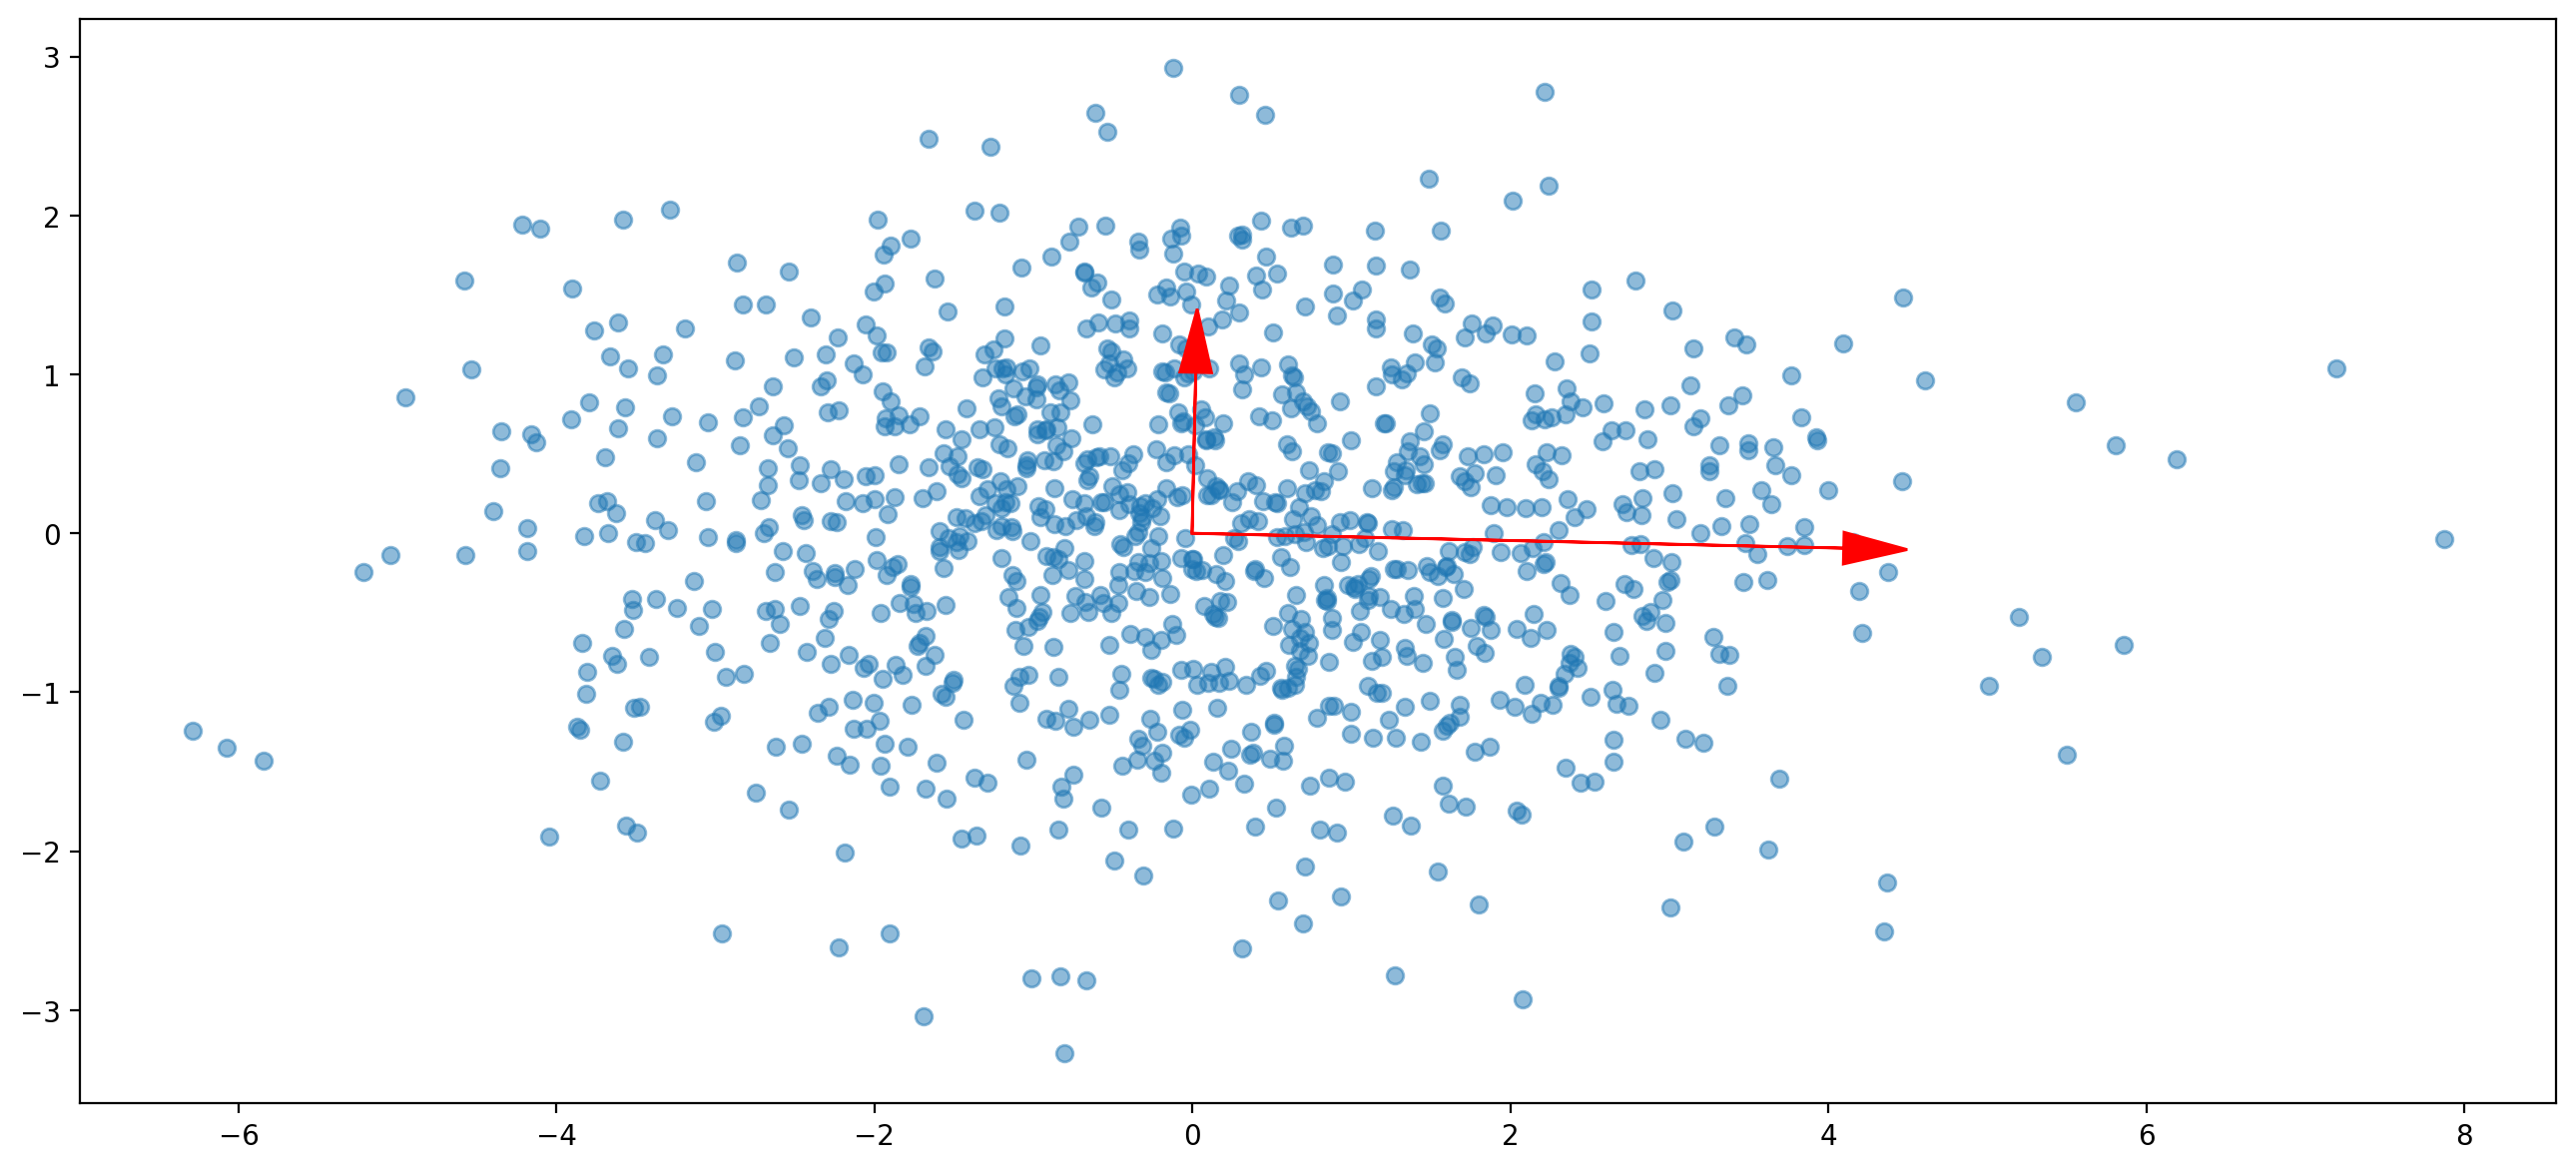

In [104]:
from sklearn.decomposition import PCA

def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)

    dec = PCA()
    dec.fit(dataset)
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]):
        component = dec.components_[comp_ind, :]
        var = dec.explained_variance_[comp_ind]
        start, end = dec.mean_, component * var
        ax.arrow(start[0], start[1], end[0], end[1],
                 head_width=0.2, head_length=0.4, fc='r', ec='r')

    ax.set_aspect('equal', adjustable='box')

plt.figure(figsize=(16, 8))
PCA_show(data_synth)

Видим, что PCA все правильно нашел. Но это, конечно, можно было сделать и просто посчитав дисперсию каждого признака. Повернем наши данные на некоторый фиксированный угол и проверим, что для PCA это ничего не изменит.

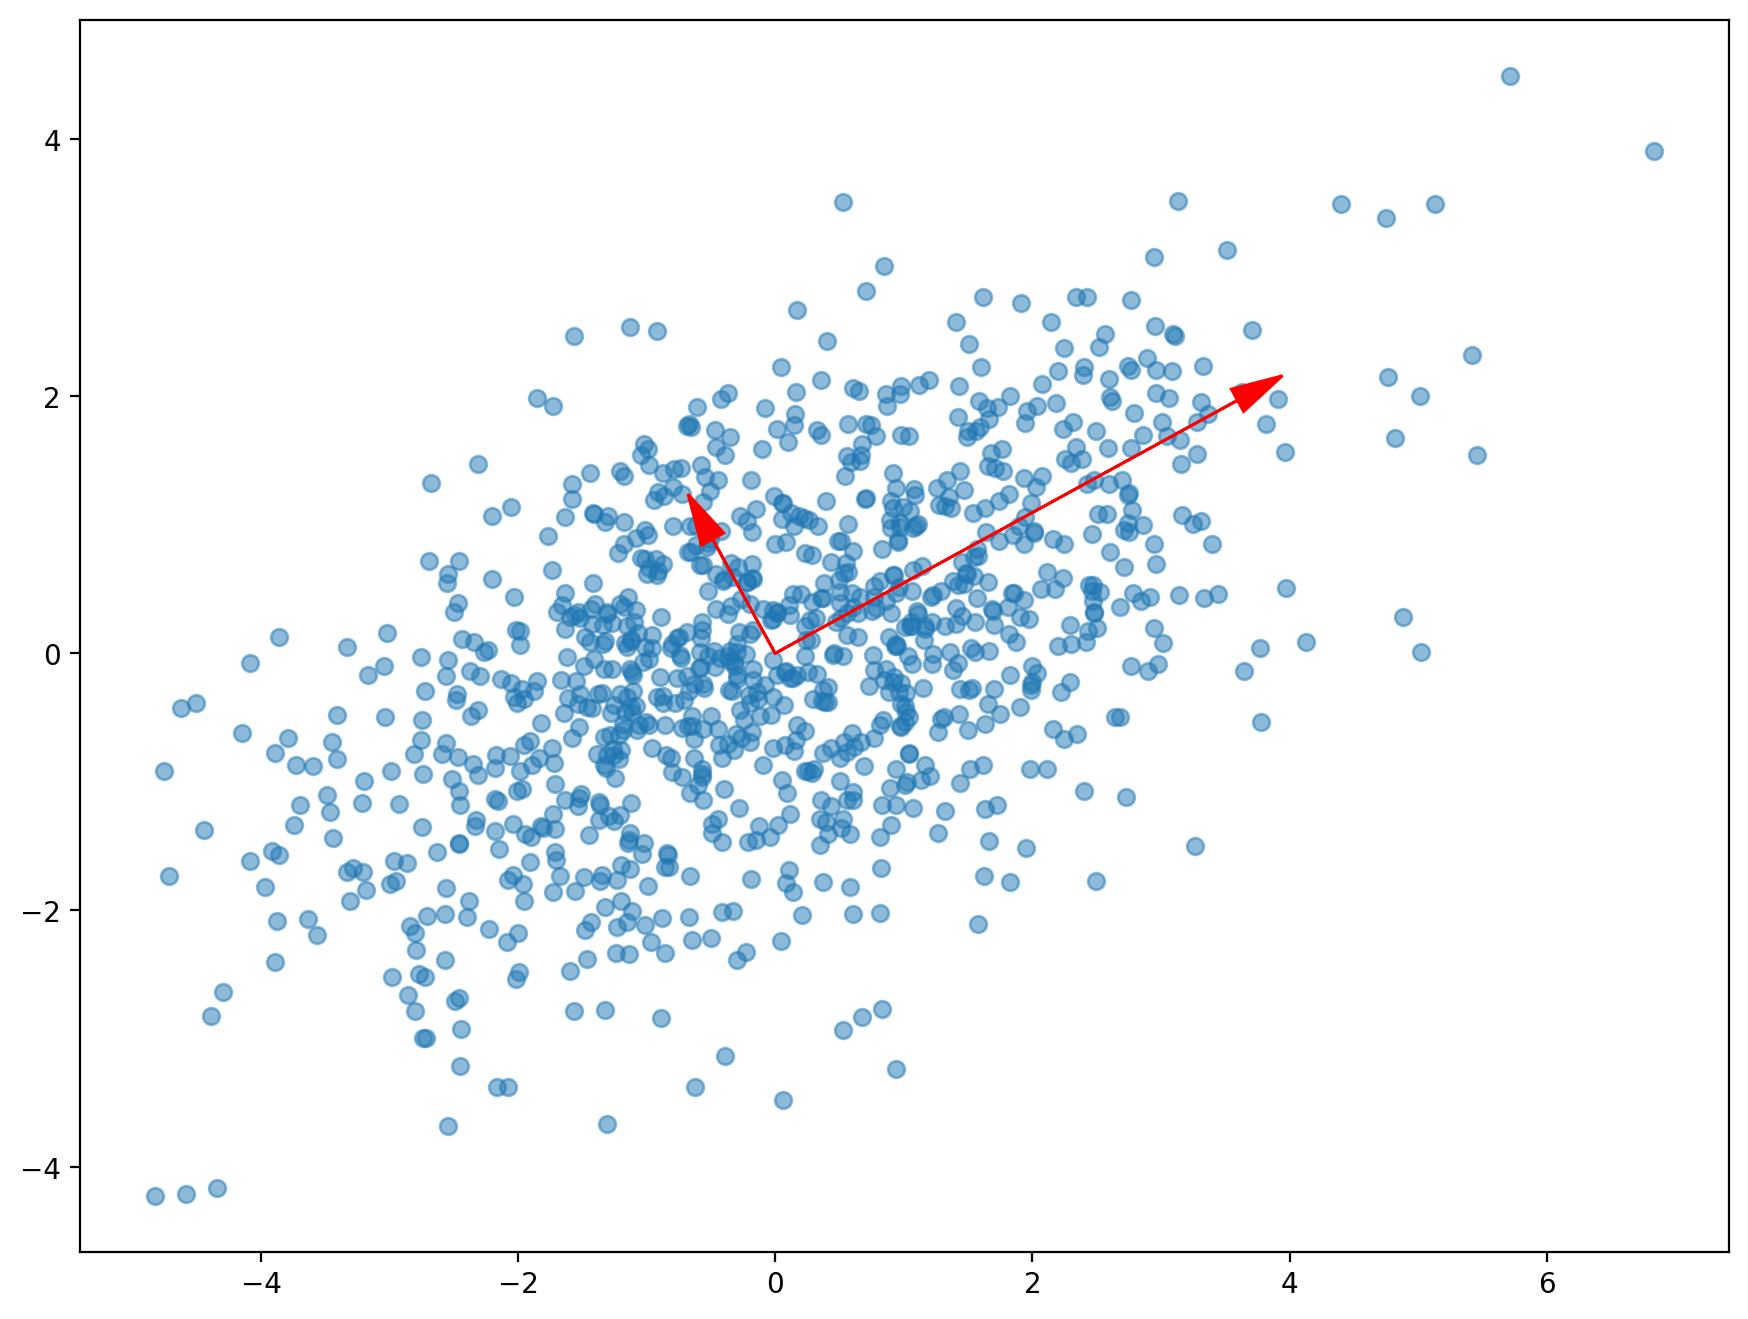

In [105]:
angle = np.pi / 6
rotate = np.array([
        [np.cos(angle), - np.sin(angle)],
        [np.sin(angle), np.cos(angle)],
    ])
data_synth_2 = rotate.dot(data_synth.T).T

plt.figure(figsize=(16, 8))
PCA_show(data_synth_2)

Ниже пара примеров, где PCA отработал не так хорошо (в том смысле, что направления задают не очень хорошие признаки).

Вопрос: почему так произошло?

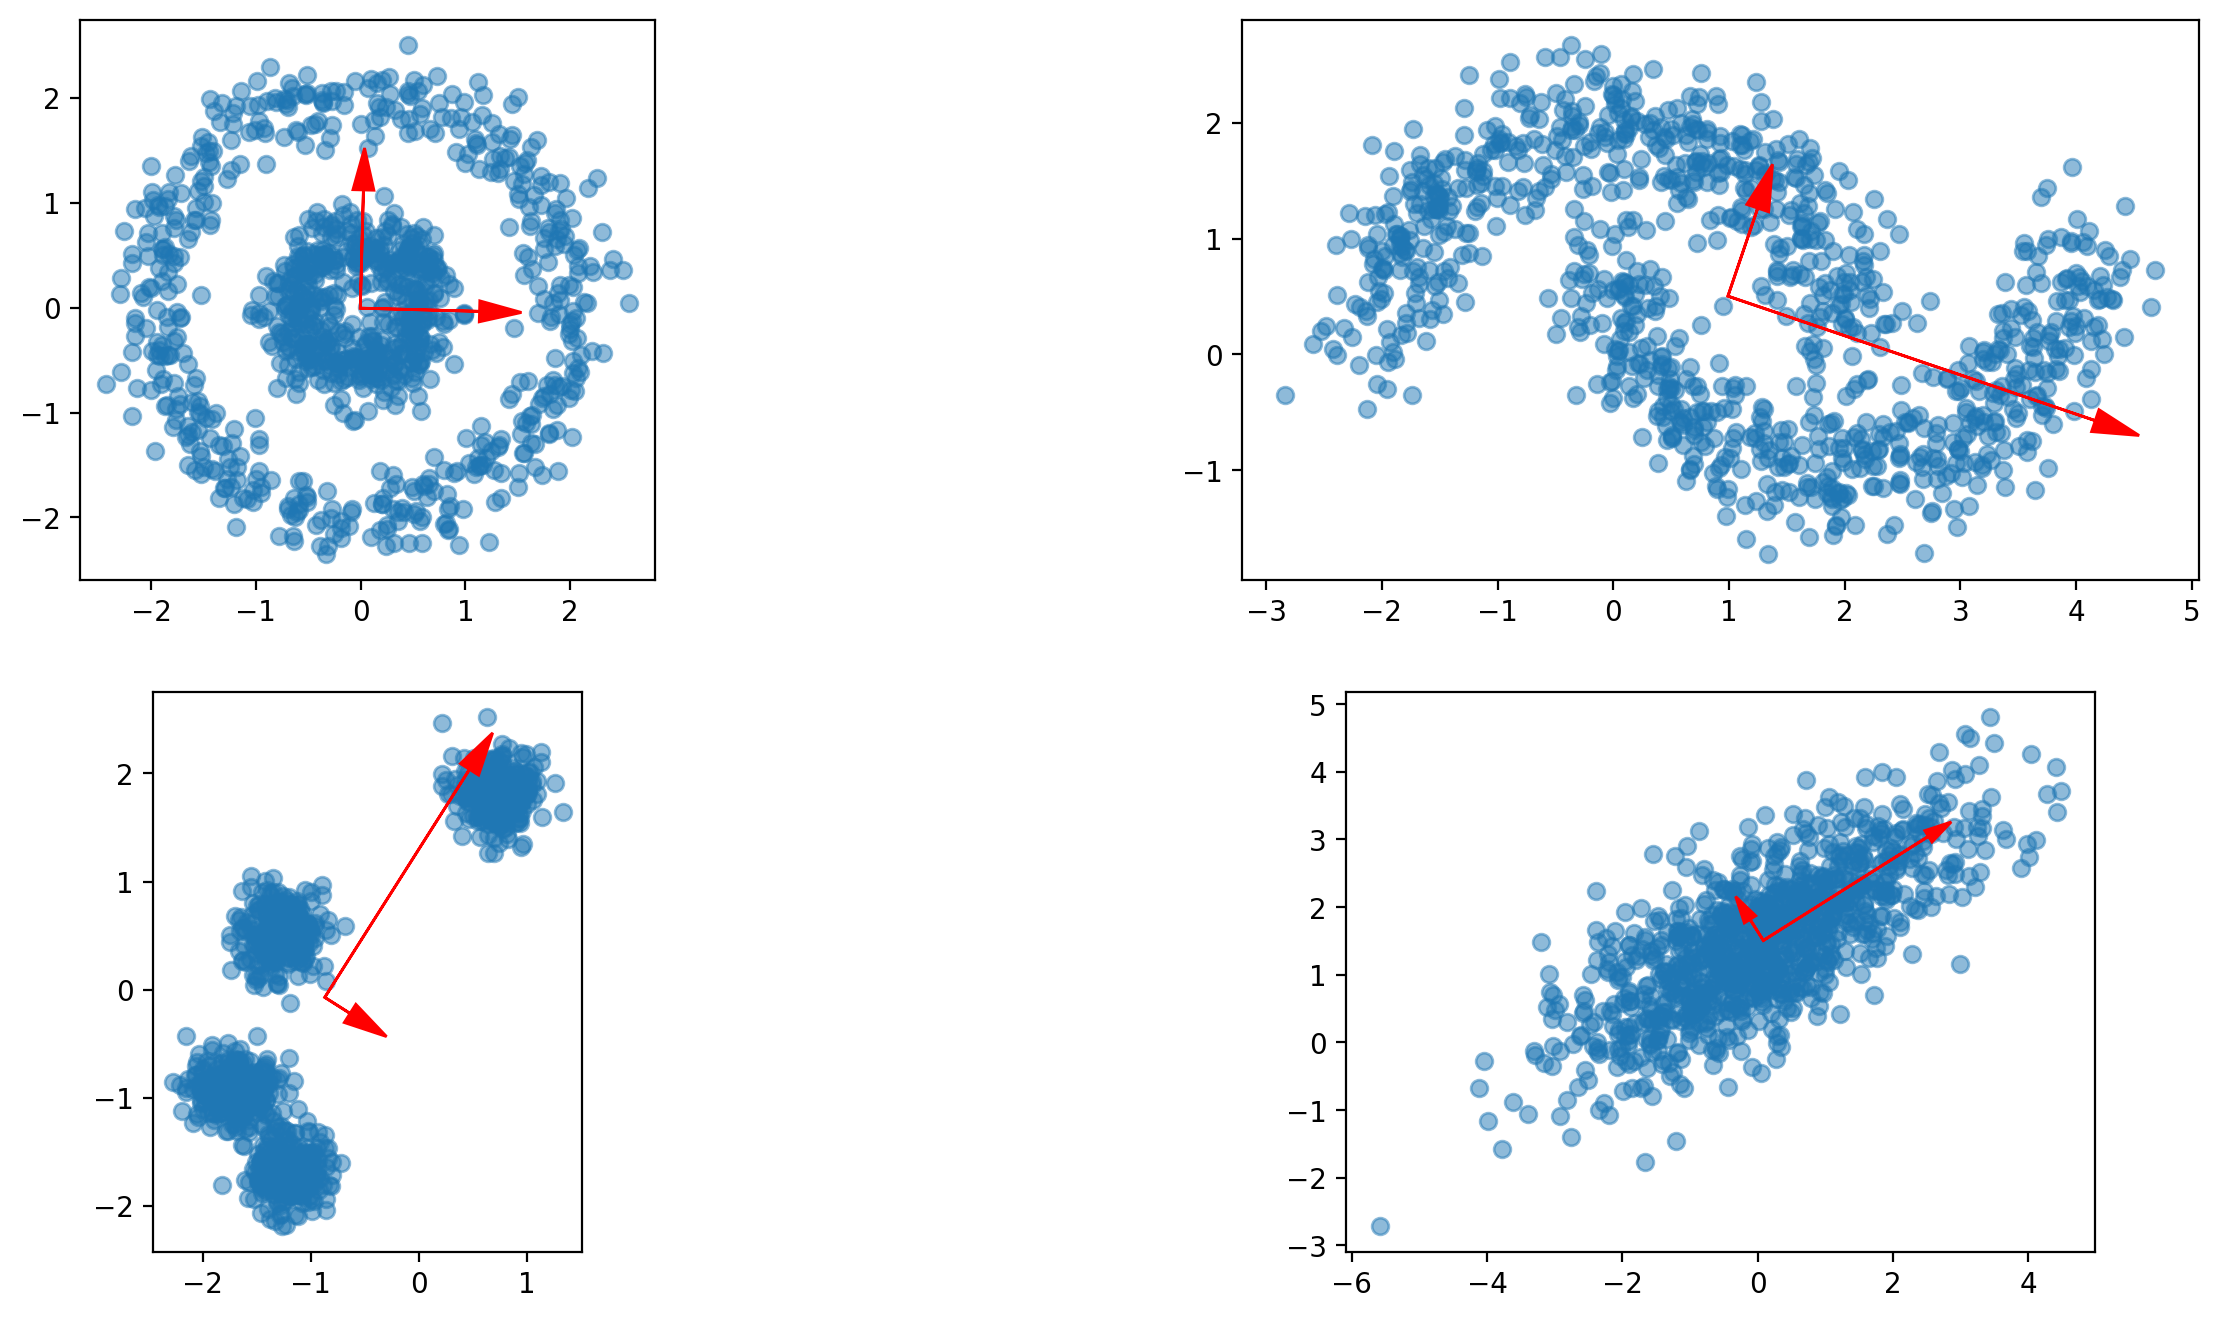

In [ ]:
np.random.seed(111) # поиграйте с сидами))

data_synth_bad = [
    make_circles(n_samples=1000, factor=0.3, noise=0.1)[0]*2,
    make_moons(n_samples=1000, noise=0.15)[0]*2,
    make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5,
    np.random.multivariate_normal(
        mean=[0, 1.5],
        cov=[[2, 1],
             [1, 1]],
        size=1000),
]

plt.figure(figsize=(16,8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

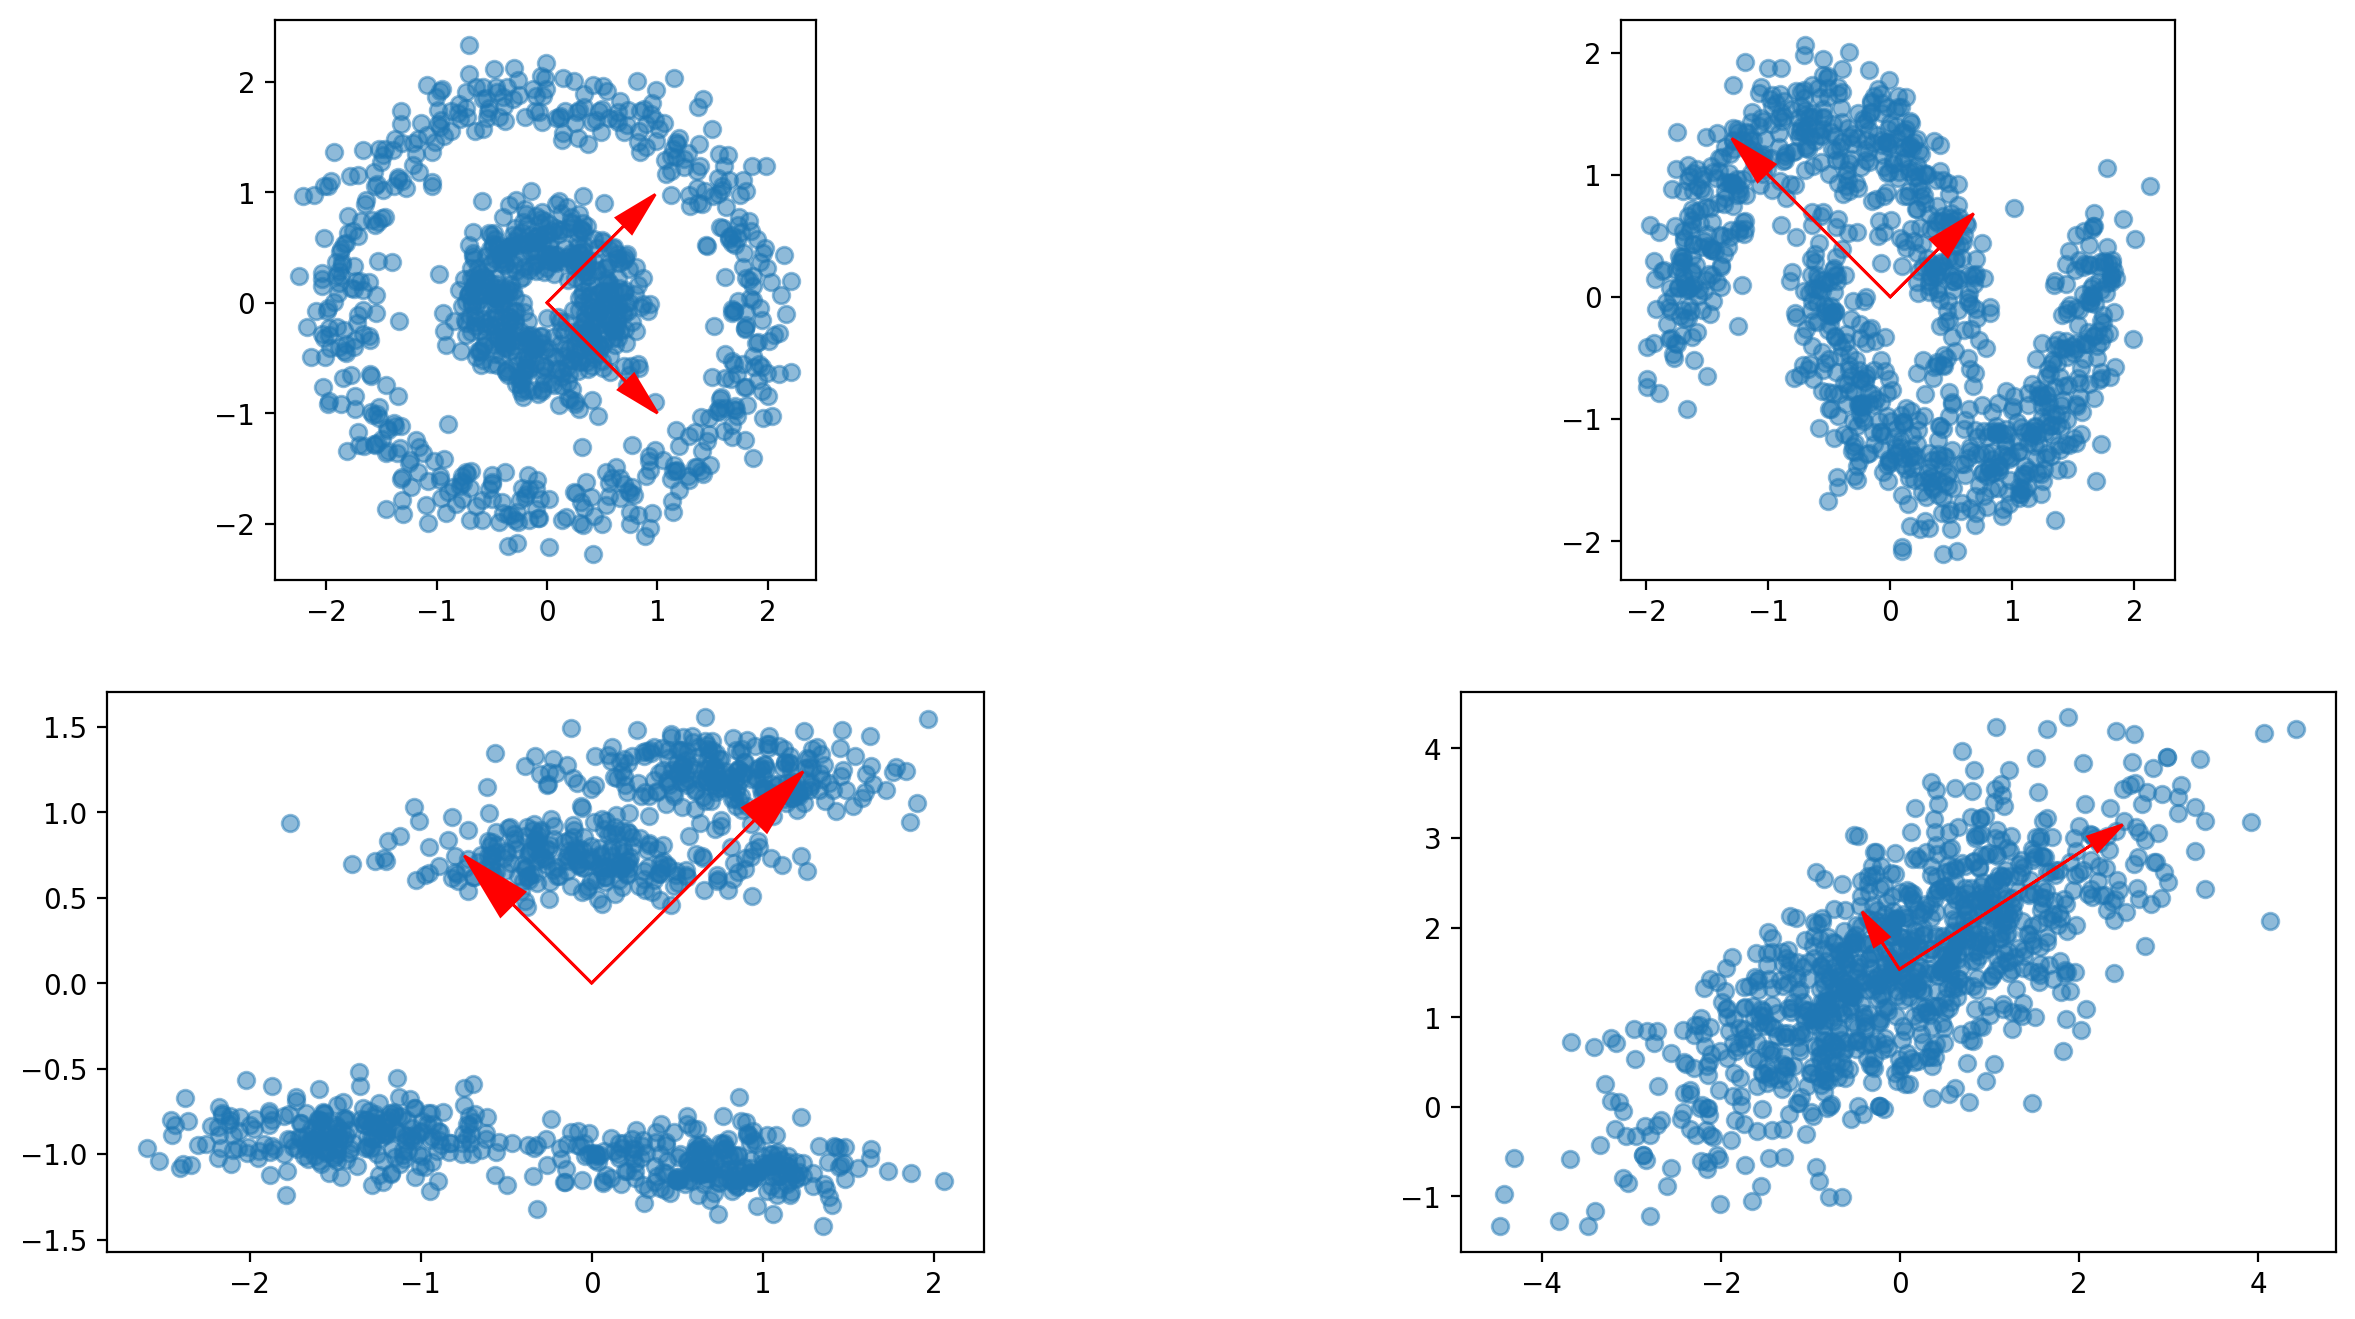

In [109]:
scaler = StandardScaler()
np.random.seed(7)

data_synth_bad = [
    scaler.fit_transform(make_circles(n_samples=1000, factor=0.3, noise=0.1)[0]*2),
    scaler.fit_transform(make_moons(n_samples=1000, noise=0.15)[0]*2),
    scaler.fit_transform(make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5),
    np.random.multivariate_normal(
        mean=[0, 1.5],
        cov=[[2, 1],
             [1, 1]],
        size=1000),
]

plt.figure(figsize=(16,8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

Доп.задание : Запустите предыдущий метод с учетом скейлинга. Поменяется ли результат?

In [108]:
pca = PCA(n_components = 5)
pipeline = Pipeline(steps=[('sc', scaler), ('pca',pca),('m',model)])
# evaluate model
pipeline.fit(X_train, y_train)
pcas = " ".join(f"{i:.2}" for i in pca.explained_variance_ratio_)
print(f"Explained {pcas} ({pca.explained_variance_ratio_.sum():.2f}) ratio of variance")
# evaluate the model
y_hat = pipeline.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_hat)
print('MAE: %.3f' % mae)

Explained 0.42 0.16 0.1 0.1 0.073 (0.85) ratio of variance
MAE: 0.222


Почему важно использование скейлинга перед проведением PCA?
Если один объект варьируется больше, чем другие, только из-за их соответствующих масштабов, PCA определит, что такой объект доминирует в направлении главных компонентов.

In [110]:
pca = PCA(n_components = 5)
pipeline = Pipeline(steps=[('pca',pca),('m',model)])
# evaluate model
pipeline.fit(X_train, y_train)
pcas = " ".join(f"{i:.2}" for i in pca.explained_variance_ratio_)
print(f"Explained {pcas} ({pca.explained_variance_ratio_.sum():.2f}) ratio of variance")
# evaluate the model
y_hat = pipeline.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_hat)
print('MAE: %.3f' % mae)

Explained 0.44 0.26 0.14 0.091 0.04 (0.96) ratio of variance
MAE: 0.211


 Какой метод наиболее страдает от проклятия размерности?
 KNN.

 Покажем это.

Рассмотрим набор MNIST - набор рукописных чисел от 0 до 9. Это один из классических наборов для компьютернорго зроения, состоящий из 100 тысяч черно-белых изображений 28х28. Однако матрицы можно и вытянуть в вектор, чтобы предсказывать класс в табличном формате. Тогда мы получим пространство признаков размера 784!

In [111]:
mnist = fetch_openml('mnist_784', cache=False)

X = mnist["data"].astype('float64')
X.reset_index()
y = mnist["target"].astype('int64')
y.reset_index()

print("\nNo. of Samples: ", X.shape)
print("No. of Labels: ", y.shape)


No. of Samples:  (70000, 784)
No. of Labels:  (70000,)


Так выглядит набор данных в табличном виде

In [112]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Рассмотрим случайный семпл в данных (преобразовав обратно в матрицу)

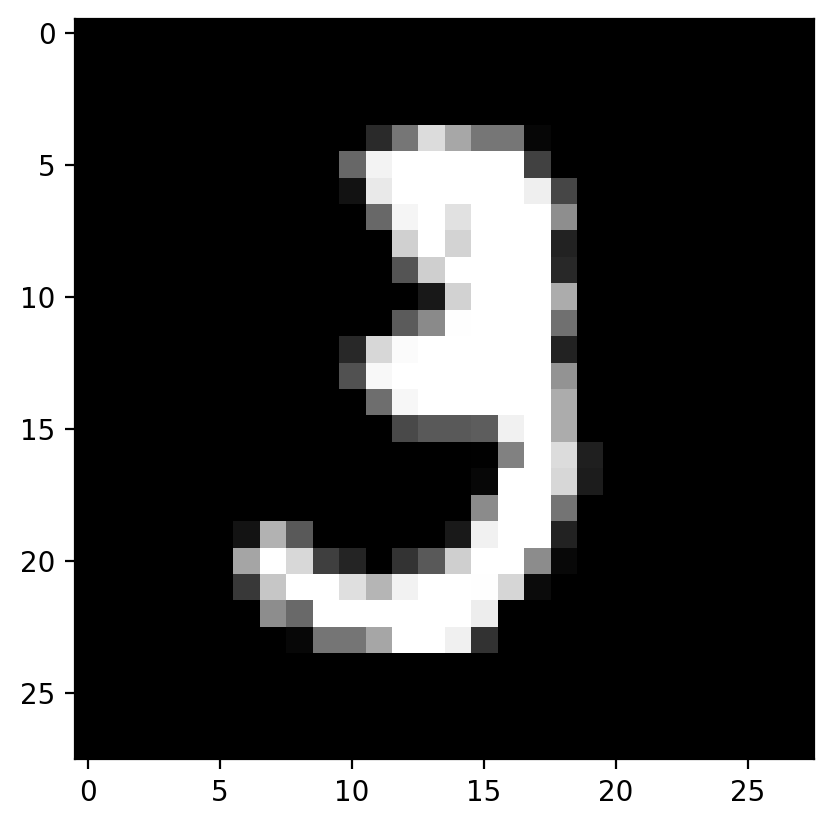

In [113]:
random_digit = X.loc[10,:].values

random_digit_image = random_digit.reshape(28, 28)

plt.imshow(random_digit_image, cmap = 'gray', interpolation="nearest")
#plt.axis("off")
plt.show()


Отнормируем

In [114]:
X /= 255.0


In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Заодно с обучением модели вспомним о поиске гиперпараметров. Что это такое?

Так как данных очень много, равномерно засемплим 1000 точек. В общем случае это плохая практика. Почему?

In [116]:
random_indices = np.random.choice(X.index, 10000, replace=False)
X_rus = X.loc[random_indices]
y_rus = y.loc[random_indices]

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=0)
print(X_train.shape, y_test.shape)

(8000, 784) (2000,)


In [119]:
param_grid = {'n_neighbors': [3, 4], 'p': [2], 'weights': ["distance"]}


knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1_micro', cv=5, verbose=1, n_jobs=-1)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_#  get best params
print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Score: 0.948250
Optimal Hyperparameter Values:  {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}




In [122]:
%%time
##########
# YOUR CODE 
# fit knn with best params

knn = KNeighborsClassifier(**params_optimal_knn)
knn.fit(X_train, y_train)
y_train_predicted = knn.predict(X_train)

train_accuracy_knn = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn)


Training Accuracy:  1.0
CPU times: user 7.32 s, sys: 555 ms, total: 7.87 s
Wall time: 1.7 s


In [123]:
%%time

y_train_pred = cross_val_predict(knn, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

CPU times: user 8.28 s, sys: 1.76 s, total: 10 s
Wall time: 1.86 s


array([[761,   1,   0,   0,   0,   2,   7,   0,   0,   0],
       [  0, 882,   3,   1,   0,   0,   1,   3,   0,   0],
       [ 10,  20, 787,   6,   0,   0,   4,  12,   3,   5],
       [  1,   8,   7, 749,   0,   8,   2,   6,   9,   5],
       [  1,  12,   1,   0, 699,   0,   3,   2,   1,  32],
       [  1,   4,   0,  13,   1, 650,  10,   2,   6,   7],
       [  5,   0,   0,   0,   0,   1, 843,   0,   0,   0],
       [  0,  18,   2,   1,   6,   0,   0, 791,   1,  25],
       [  5,  18,   2,  19,   4,  19,   4,   1, 674,  13],
       [  3,   5,   0,   6,   8,   3,   1,  23,   1, 750]])

In [124]:

y_test_predicted = knn.predict(X_test)

test_accuracy_knn = np.mean(y_test_predicted == y_test)
print("\nTraining Accuracy: ", test_accuracy_knn)


Training Accuracy:  0.945


In [125]:
%%time

# The accuracy of the model
test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)


# No. of Correct Predictions
y_test_predicted = knn.predict(X_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))


# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))


Test Accuracy:  0.945

No. of correct predictions (Test): 1890/2000

Confusion Matrix (Test Data):
 [[195   0   1   0   0   0   5   0   0   0]
 [  0 252   0   1   0   0   0   0   0   0]
 [  1   4 180   1   0   0   1   4   2   1]
 [  0   0   2 183   0   4   1   1   1   1]
 [  0   3   0   0 166   0   2   1   0   6]
 [  1   1   0   5   0 187   5   0   1   4]
 [  0   1   1   0   0   0 182   0   0   0]
 [  0   2   1   0   1   0   0 197   0   8]
 [  0   5   2   4   1   8   1   0 168   3]
 [  1   0   1   2   2   2   0   2   2 180]]
CPU times: user 3.4 s, sys: 355 ms, total: 3.76 s
Wall time: 775 ms


In [126]:
pd.crosstab(y_test, y_test_predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,195,0,1,0,0,0,5,0,0,0,201
1,0,252,0,1,0,0,0,0,0,0,253
2,1,4,180,1,0,0,1,4,2,1,194
3,0,0,2,183,0,4,1,1,1,1,193
4,0,3,0,0,166,0,2,1,0,6,178
5,1,1,0,5,0,187,5,0,1,4,204
6,0,1,1,0,0,0,182,0,0,0,184
7,0,2,1,0,1,0,0,197,0,8,209
8,0,5,2,4,1,8,1,0,168,3,192


Попробуем уменьшить влияние проклятия размерности с помощью уменьшения размерности, использовав метод PCA.

In [127]:
%%time
pca = PCA(n_components=0.95)
pca.fit(X_train)

print("Number of Principle Components: ", pca.n_components_)

Number of Principle Components:  151
CPU times: user 5.15 s, sys: 174 ms, total: 5.32 s
Wall time: 1.08 s


In [128]:
#################
# YOUR CODE
# Transform x train and test
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
###################

In [129]:
%%time


knn_pca = KNeighborsClassifier(n_neighbors=4, p=2, weights="distance")

knn_pca.fit(X_train_pca, y_train)


y_test_predicted_pca_knn = knn_pca.predict(X_test_pca)
print("KNN (PCA): Test Accuracy: ", accuracy_score(y_test, y_test_predicted_pca_knn))

print("\nKNN (PCA): Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_pca_knn))

print("\nKNN (PCA): Classification Report:")
print(classification_report(y_test, y_test_predicted_pca_knn))

print("\n")

KNN (PCA): Test Accuracy:  0.945

KNN (PCA): Test Confusion Matrix:
[[195   0   1   0   0   0   5   0   0   0]
 [  0 251   0   2   0   0   0   0   0   0]
 [  1   3 180   2   0   0   1   4   2   1]
 [  0   0   2 183   0   4   1   1   1   1]
 [  0   3   0   0 165   0   2   2   0   6]
 [  1   1   0   4   0 188   5   0   1   4]
 [  0   1   1   0   0   0 182   0   0   0]
 [  0   3   1   0   1   0   0 196   0   8]
 [  0   4   2   3   1   7   1   1 169   4]
 [  0   0   1   2   1   2   0   3   2 181]]

KNN (PCA): Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       201
           1       0.94      0.99      0.97       253
           2       0.96      0.93      0.94       194
           3       0.93      0.95      0.94       193
           4       0.98      0.93      0.95       178
           5       0.94      0.92      0.93       204
           6       0.92      0.99      0.96       184
           7       0.95      0.94

Мы видим, что после уменьшения размерности мы можем снизить стоимость расчета расстояния в K-NN, что приводит к значительному сокращению времени обучения. При этом мы не потеряли в точности, а даже выиграли!

Для сравнения времени обучения рассмотрим метод, построенный не на расстоянии - случайный лес. Эта модель будет страдать от проклятия размерности в терминах времени меньше.

In [130]:
%%time

forest_clf = RandomForestClassifier(n_estimators=1000, criterion="gini", 
                                    max_depth=32, class_weight="balanced", oob_score=True, verbose=1, n_jobs=-1)

forest_clf.fit(X_train, y_train)

y_test_predicted_rf = forest_clf.predict(X_test)
print("Random Forest: Test Accuracy: ", accuracy_score(y_test, y_test_predicted_rf))

print("\nRandom Forest: Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_rf))

print("\nRandom Forest: Classification Report:")
print(classification_report(y_test, y_test_predicted_rf))

print("\n")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   11.0s finished


Random Forest: Test Accuracy:  0.9415

Random Forest: Test Confusion Matrix:
[[197   0   1   0   1   0   2   0   0   0]
 [  0 250   1   2   0   0   0   0   0   0]
 [  1   1 184   2   0   0   1   1   4   0]
 [  0   0   3 180   0   6   0   0   2   2]
 [  0   0   1   0 166   0   3   2   0   6]
 [  2   0   3   7   1 181   6   0   2   2]
 [  0   1   0   0   0   1 182   0   0   0]
 [  0   1   7   0   1   0   0 193   0   7]
 [  0   6   1   4   1   3   2   0 169   6]
 [  0   0   1   3   2   2   0   2   1 181]]

Random Forest: Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       201
           1       0.97      0.99      0.98       253
           2       0.91      0.95      0.93       194
           3       0.91      0.93      0.92       193
           4       0.97      0.93      0.95       178
           5       0.94      0.89      0.91       204
           6       0.93      0.99      0.96       184
           7       0

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.1s finished


In [131]:
%%time

forest_clf = RandomForestClassifier(n_estimators=1000, criterion="gini", 
                                    max_depth=32, class_weight="balanced", oob_score=True, verbose=1, n_jobs=-1)

forest_clf.fit(X_train_pca, y_train)

y_test_predicted_rf = forest_clf.predict(X_test_pca)
print("Random Forest: Test Accuracy: ", accuracy_score(y_test, y_test_predicted_rf))

print("\nRandom Forest: Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_rf))

print("\nRandom Forest: Classification Report:")
print(classification_report(y_test, y_test_predicted_rf))

print("\n")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   26.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s


Random Forest: Test Accuracy:  0.922

Random Forest: Test Confusion Matrix:
[[194   0   1   1   2   0   3   0   0   0]
 [  0 247   1   2   0   1   0   0   2   0]
 [  0   1 182   2   0   0   1   2   4   2]
 [  0   0   4 175   0   6   2   1   3   2]
 [  0   2   1   0 160   0   2   1   3   9]
 [  1   0   3   8   1 178   9   0   2   2]
 [  2   1   2   0   0   1 177   0   1   0]
 [  0   1   8   0   2   0   0 192   0   6]
 [  0   5   4   7   4   3   2   0 161   6]
 [  1   0   0   5   4   0   0   3   1 178]]

Random Forest: Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       201
           1       0.96      0.98      0.97       253
           2       0.88      0.94      0.91       194
           3       0.88      0.91      0.89       193
           4       0.92      0.90      0.91       178
           5       0.94      0.87      0.91       204
           6       0.90      0.96      0.93       184
           7       0.

[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


Как видно, обучение произошло гораздо быстрее, при этом точность алгоритма даже выше, чем у KNN

## Проиллюстрируем

In [132]:
def process_image(filename, size=64):
    with Image.open(filename) as img:
        # Convert to grayscale and resize
        img = img.convert('L').resize((size, size))
        
        # Convert to numpy array with channel dimension
        arr = np.array(img, dtype=np.uint8)[..., np.newaxis]
        return arr

Создадим небольшой датасет с картинками котов. Для простоты переведем ихз в черно-белую гамму и сделаем их размера 64 на 64. ПОсмотрим, что получится. При этом выведем еще и "среднего кота". Потом нам это понадобится для PCA.

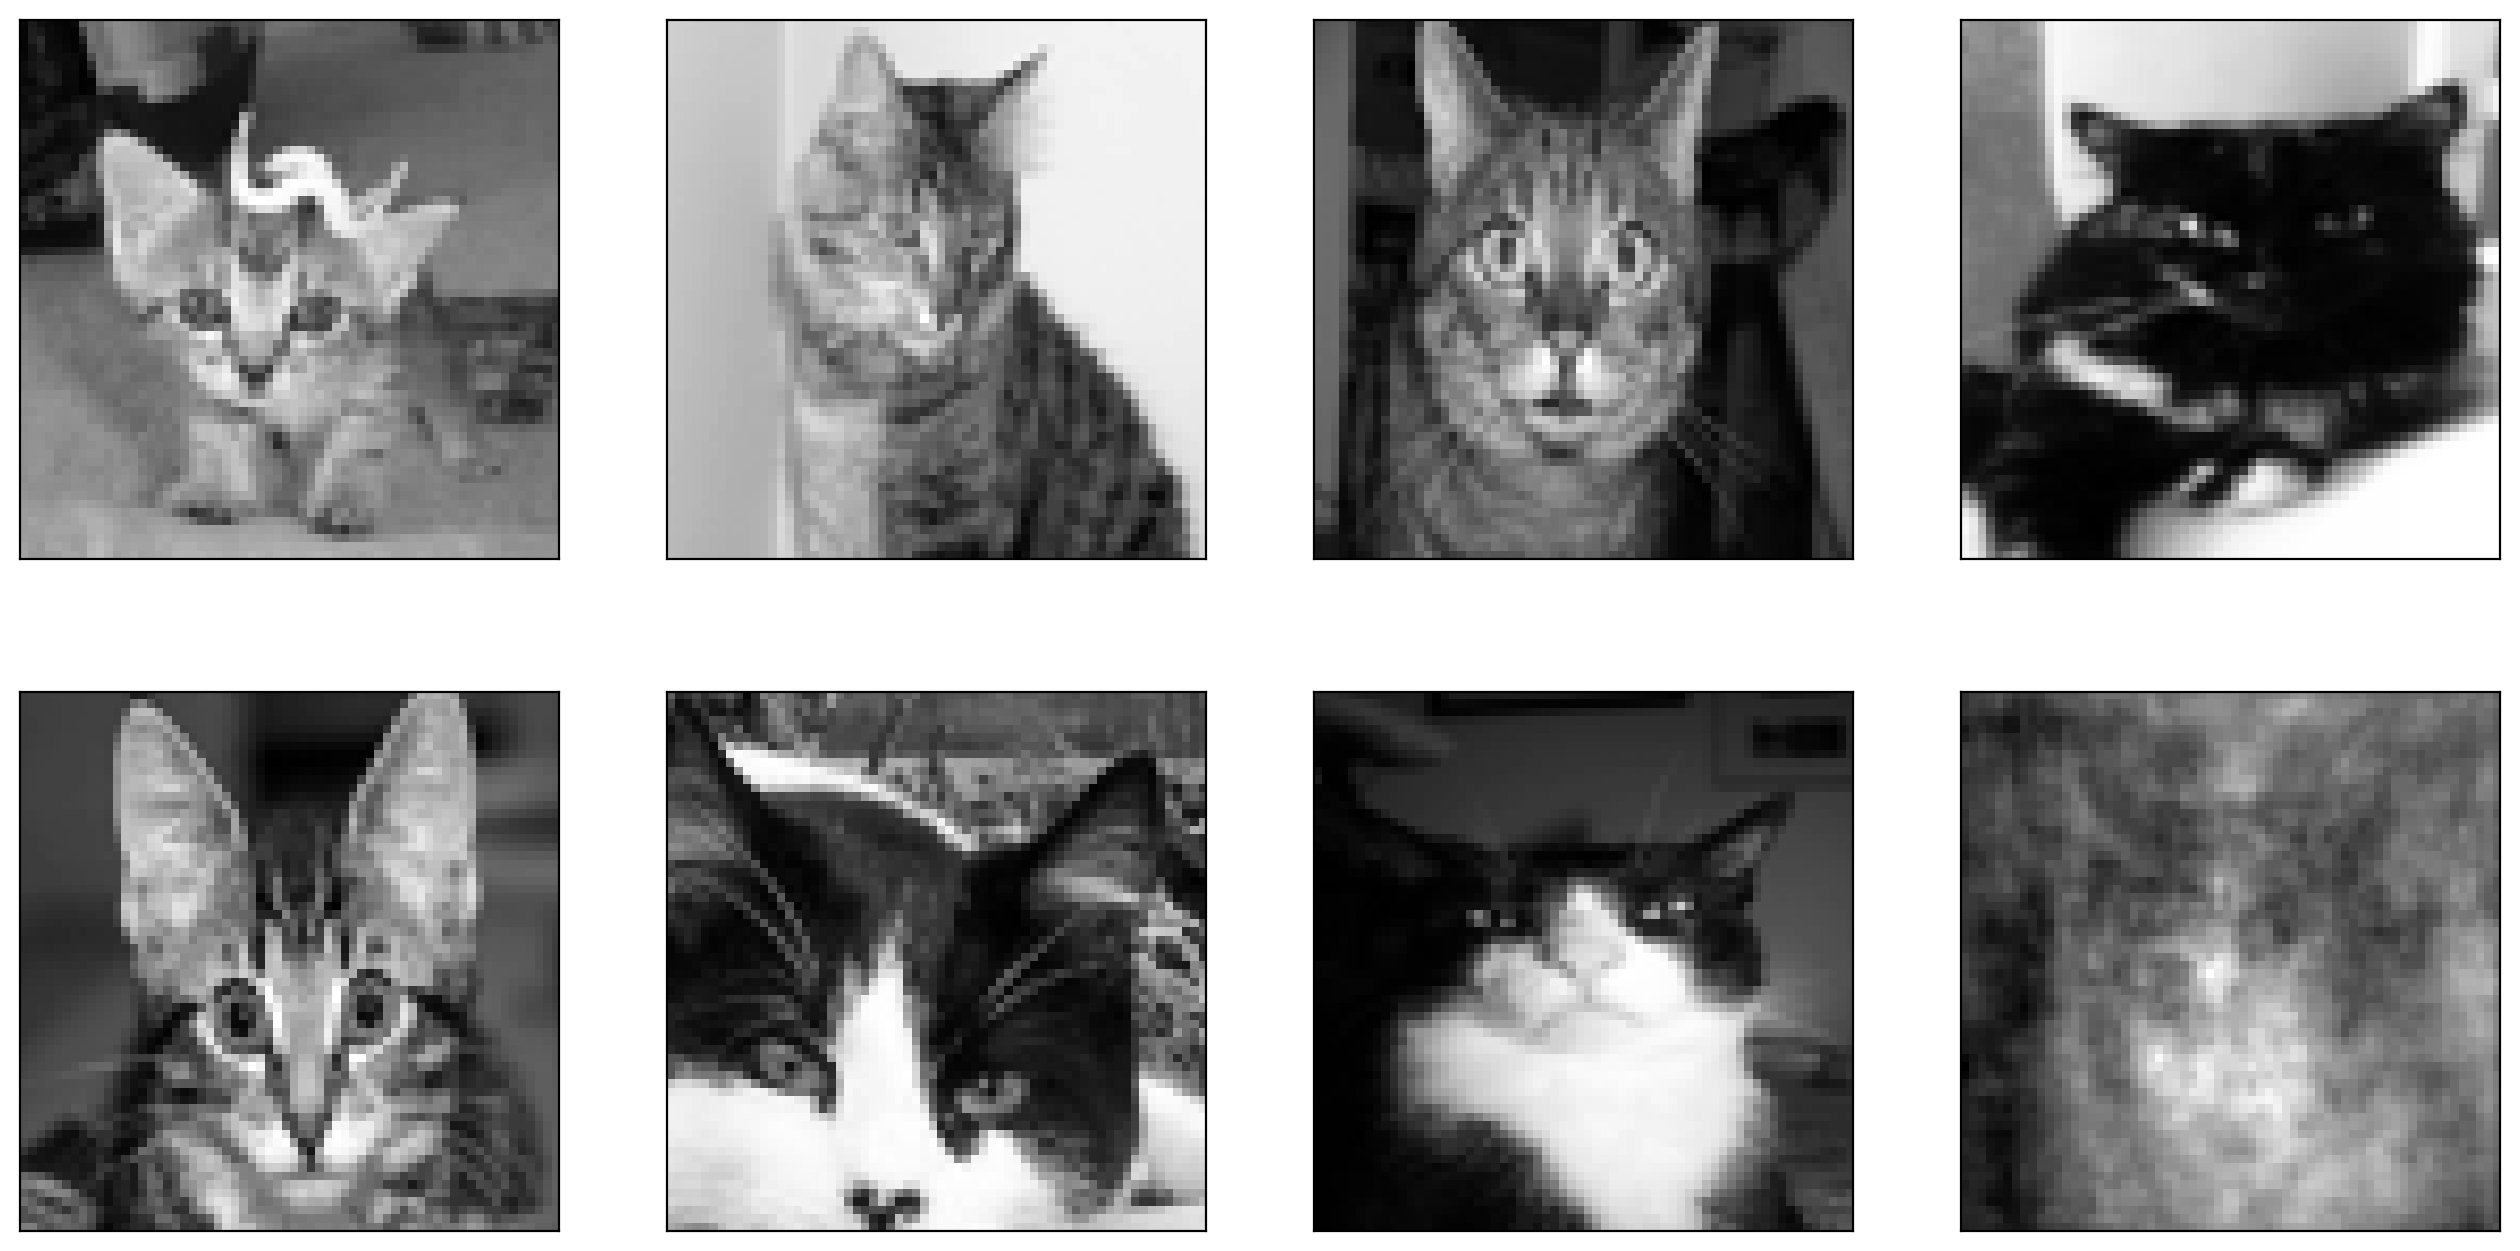

In [133]:
from PIL import Image
import random
random.seed(1234)
cats_path = os.path.join(data_path, "base_cats")
image_shape = (64, 64)
rows, cols = 2, 4
n_samples = rows * cols

all_files = [f for f in os.listdir(cats_path ) 
                if f.lower().endswith(('.jpg', '.jpeg'))]
processed = []
for filename in random.sample(all_files, 120):
    processed.append(process_image(os.path.join(cats_path, filename)))
    
sample = random.sample(processed, n_samples)
cats_data = np.array(processed, dtype=np.float32)

mean_cat = cats_data.mean(axis=0)

plt.figure(figsize=(16, 8))

for i in range(n_samples - 1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cats_data[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
plt.subplot(rows, cols, n_samples)
plt.imshow(mean_cat.reshape(image_shape), interpolation='none',
           cmap='gray')
plt.xticks(())
_ = plt.yticks(())

Применим к ним PCA. Найдем первые главные компоненты

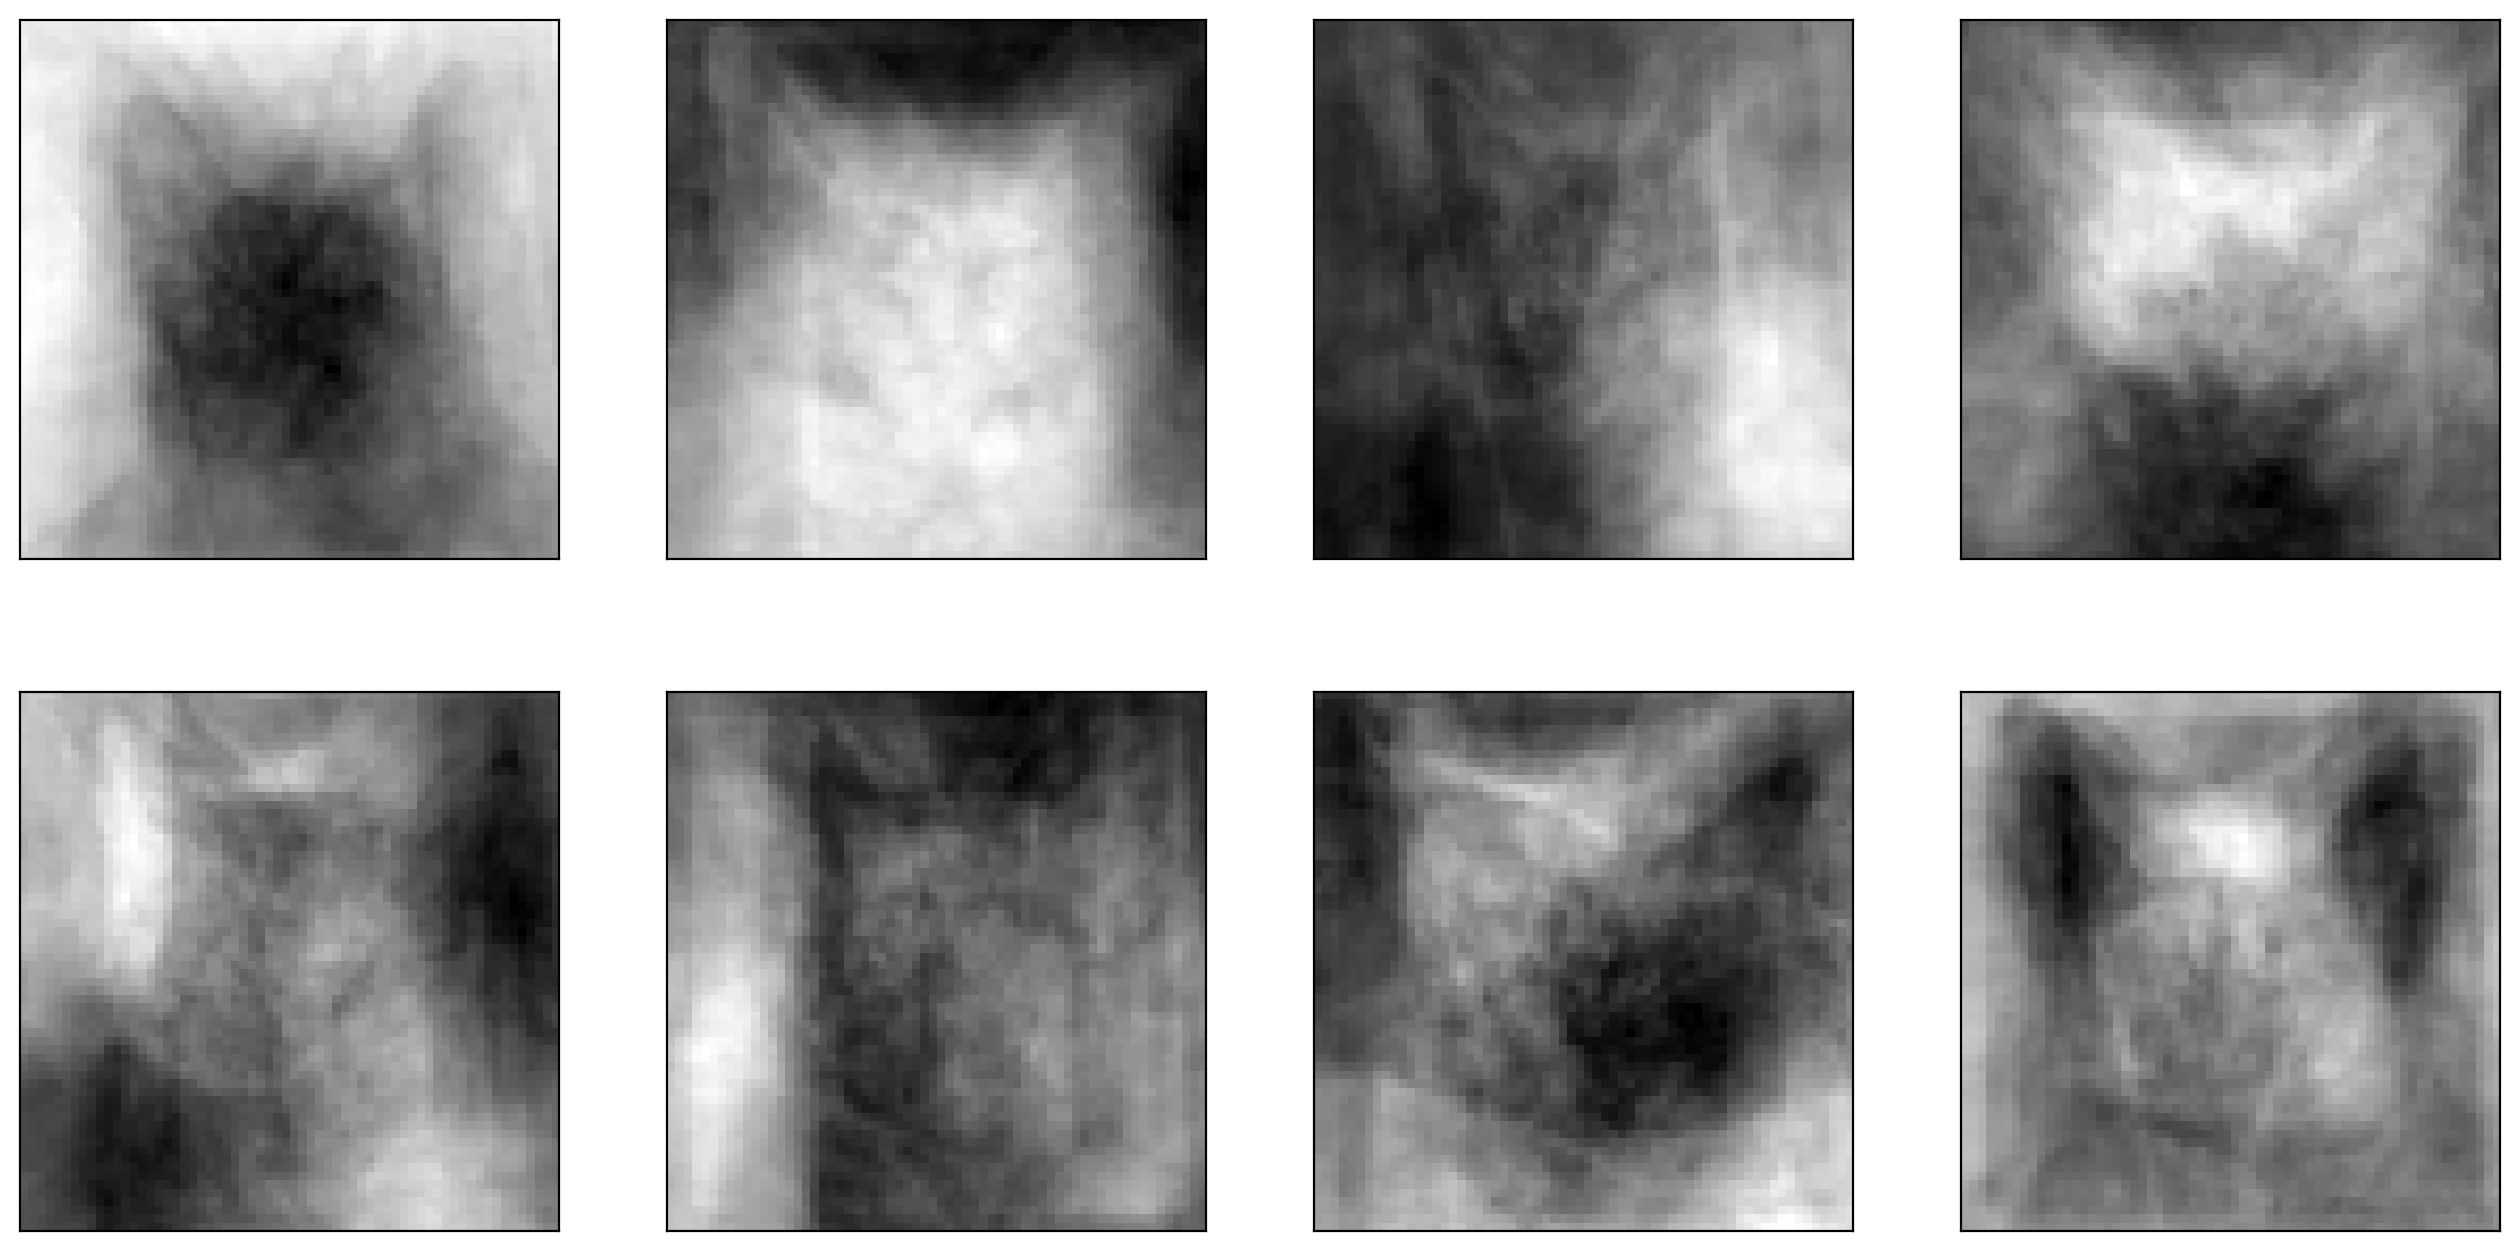

In [134]:
model_pca = PCA()
cats_data -= mean_cat  # отнормировали данные к нулевому среднему
model_pca.fit(cats_data.reshape(-1, 64*64))

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(model_pca.components_[i, :].reshape(image_shape), interpolation='none', cmap='gray')
    plt.xticks(())
    plt.yticks(())

Получились забавные призраки! Обратите внимание, что это не изображение котов, а именно компоненты - или собственные векторы $X^T X$.